## HW 4
## Name: Surya Roshan Mugada
## USC ID: 6545904818
## Github : Roshan-99

#Reference :
https://machinelearningmastery.com/rfe-feature-selection-in-python/

### This is the same part of code as HW3. I included this since it builds the data necessary for HW4 to use. I indicated the cell where HW4 begins

In [1]:
import os 
import pandas as pd
import numpy as np
from scipy.stats import bootstrap
import numpy as np
import seaborn as sns
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
import statsmodels.api as sm
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## 1 b) Splitting data into train and test 

#### Function to read the instances in the folder. It takes input of the root folder and the list of instances which are used for testing

In [2]:
def convert_csv_to_dataset(root_folder,test_list):
    folder_path='../Data/'+root_folder+'/'
    test_list=['dataset'+str(x)+'.csv' for x in test_list]
    #print(test_list)
    files=os.listdir(folder_path)
    train_data,test_data=[],[]
    for file in files:
        file_path=folder_path+file
        #print(file_path)
        df=pd.read_csv(file_path,skiprows=4)
        #display(df)
        if file in test_list:
            test_data.append(df)
        else:
            train_data.append(df)
    train_dict=[root_folder,train_data]
    test_dict=[root_folder,test_data]
    return train_dict,test_dict

In [3]:
def build_data(train_list,test_list,data):
    #print(train_list)
    train_dict=data[0]
    test_dict=data[1]
    #print(train_dict[1])
    train_list[train_dict[0]]=train_dict[1]
    #train_list.append(data[0])
    test_list[test_dict[0]]=test_dict[1]

#### Build a train & test data with key as class and value as list of data

In [4]:
train_data,test_data={},{}
build_data(train_data,test_data,convert_csv_to_dataset('bending1',[1,2]))
build_data(train_data,test_data,convert_csv_to_dataset('bending2',[1,2]))
build_data(train_data,test_data,convert_csv_to_dataset('cycling',[1,2,3]))
build_data(train_data,test_data,convert_csv_to_dataset('lying',[1,2,3]))
build_data(train_data,test_data,convert_csv_to_dataset('sitting',[1,2,3]))
build_data(train_data,test_data,convert_csv_to_dataset('standing',[1,2,3]))
build_data(train_data,test_data,convert_csv_to_dataset('walking',[1,2,3]))

In [5]:
train_data['bending1'][0]

# Columns: time  avg_rss12  var_rss12  avg_rss13  var_rss13  avg_rss23  \
0                  0      42.00       0.71      21.25       0.43      30.00   
1                250      41.50       0.50      20.25       1.48      31.25   
2                500      41.50       0.50      14.25       1.92      33.00   
3                750      40.75       0.83      15.75       0.43      33.00   
4               1000      40.00       0.71      20.00       2.74      32.75   
..               ...        ...        ...        ...        ...        ...   
475           118750      42.50       0.50      20.00       0.82      36.00   
476           119000      42.67       0.47      21.00       0.00      36.33   
477           119250      44.33       0.94      21.00       0.00      36.33   
478           119500      45.25       0.43      26.75       1.79      36.00   
479           119750      47.25       0.83      29.75       0.43      35.25   

     var_rss23  
0         0.00  
1         1.09  
2         0.00  
3         0.00  
4         0.43  
..         ...  
475       0.00  
476       0.47  
477       0.47  
478       0.00  
479       1.30  

[480 rows x 7 columns]

## 1) C) Feature Extraction

### i) Time domain features used in time series classification are Minimum, Maximum, Median, Mean, Standard deviation, interquartile values, slope, correlation structure, entropy, stationarity, Skewness, Kurtosis, etc are some of the features that could be used in time series classification

### ii) Extract Minimum, Maximum, Mean, Median, Standard Deviation, First Quartile, Third Quartile for each of the 6 time series and making the new dataset

In [6]:
train_data_new,test_data_new=[],[]

#### Finding min, max, mean, median, std, 1st quartile and 3rd quartile for all timeseries instance

In [7]:
def make_columns(value,label,train_or_test):
    #display(value)
    new_column=[]
    old_data_columns=value.columns
    i=0
    for col in old_data_columns:
        new_column.append(i)
        i+=1
    #print(new_column)
    value.columns=new_column
    min_=value.min()
    max_=value.max()
    mean_=value.mean()
    std_=value.std()
    median_=value.median()
    first_quartile=value.quantile(0.25)
    third_quartile=value.quantile(0.75)
    #print(old_data_columns[0])
    row=[]
    
    #print(value.columns)
    for column in value.columns:
        row.append(min_[column])
        row.append(max_[column])
        row.append(mean_[column])
        row.append(std_[column])
        row.append(median_[column])
        row.append(first_quartile[column])
        row.append(third_quartile[column])
    row.append(label)
    row.append(train_or_test)
    return row
    #print(row)

#### building new dataset from the dataset obtained in part b

In [8]:
def make_new_dataset(data,train_or_test):
    #get the number of features in the data
    #col1=[str(x) for x in range(1,len(train_data[list(data.keys())[0]][0].columns)*column_multiplier)]
    col1=[str(x) for x in range(1,7)]
    col2=['min','max','mean','std','median','1st quart','3rd quart']
    new_col=[]
    for right in col1:
        for left in col2:
            new_col.append(left+right)
    new_col.append('class')
    new_col.append('train_or_test')
    #print(new_col)
    data_new=[]
    for key in data:
        #print(key)
        for value in data[key]:
            
            value=value.copy().drop(columns=value.columns[0])
            #split=len(value)//column_multiplier
            #display(value)
            #print(key)
            
            
            #display(new_value)
            data_new.append(make_columns(value,key,train_or_test))
    #print(len(data_new))
    return pd.DataFrame(data_new,columns=new_col)

In [9]:
train_df=make_new_dataset(train_data,'train')
train_df

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
0   35.00  47.40  43.954500  1.558835   44.330       43.00     45.0000   0.0   
1   33.00  47.75  42.179813  3.670666   43.500       39.15     45.0000   0.0   
2   33.00  45.75  41.678063  2.243490   41.750       41.33     42.7500   0.0   
3   37.00  48.00  43.454958  1.386098   43.250       42.50     45.0000   0.0   
4   36.25  48.00  43.969125  1.618364   44.500       43.31     44.6700   0.0   
..    ...    ...        ...       ...      ...         ...         ...   ...   
64  20.75  46.25  34.763333  4.742208   35.290       31.67     38.2500   0.0   
65  21.50  51.00  34.935813  4.645944   35.500       32.00     38.0625   0.0   
66  18.33  47.67  34.333042  4.948770   34.750       31.25     38.0000   0.0   
67  18.33  45.75  34.599875  4.731790   35.125       31.50     38.0000   0.0   
68  15.50  43.67  34.225875  4.441798   34.750       31.25     37.2500   0.0   

     max2     mean2  ...  3rd quart5  min6   max6     mean6      std6  \
0    1.70  0.426250  ...       36.50   0.0   1.79  0.493292  0.513506   
1    3.00  0.696042  ...       36.33   0.0   2.18  0.613521  0.524317   
2    2.83  0.535979  ...       31.25   0.0   1.79  0.383292  0.389164   
3    1.58  0.378083  ...       24.00   0.0   5.26  0.679646  0.622534   
4    1.50  0.413125  ...       23.75   0.0   2.96  0.555313  0.487826   
..    ...       ...  ...         ...   ...    ...       ...       ...   
64  12.68  4.223792  ...       18.33   0.0   9.39  3.288271  1.647528   
65  12.21  4.115750  ...       18.25   0.0  10.21  3.280021  1.700918   
66  12.48  4.396958  ...       18.00   0.0   8.01  3.261583  1.617290   
67  15.37  4.398833  ...       18.25   0.0   8.86  3.289542  1.680170   
68  17.24  4.354500  ...       18.25   0.0   9.42  3.479542  1.761146   

    median6  1st quart6  3rd quart6     class  train_or_test  
0     0.430        0.00      0.9400  bending1          train  
1     0.500        0.00      1.0000  bending1          train  
2     0.430        0.00      0.5000  bending1          train  
3     0.500        0.43      0.8700  bending1          train  
4     0.490        0.00      0.8300  bending1          train  
..      ...         ...         ...       ...            ...  
64    3.270        2.05      4.3050   walking          train  
65    3.015        2.12      4.5000   walking          train  
66    2.980        2.05      4.3200   walking          train  
67    3.015        2.12      4.2600   walking          train  
68    3.270        2.24      4.5375   walking          train  

[69 rows x 44 columns]

In [10]:
test_df=make_new_dataset(test_data,'test')
test_df

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
0   37.25  45.00  40.624792  1.476967   40.500     39.2500     42.0000   0.0   
1   38.00  45.67  42.812812  1.435550   42.500     42.0000     43.6700   0.0   
2   12.75  51.00  24.562958  3.737514   24.250     23.1875     26.5000   0.0   
3    0.00  42.75  27.464604  3.583582   28.000     25.5000     30.0000   0.0   
4   24.25  45.00  37.177042  3.581301   36.250     34.5000     40.2500   0.0   
5   28.75  44.75  37.561188  3.226507   36.875     35.2500     40.2500   0.0   
6   22.00  44.67  37.058708  3.710180   36.000     34.5000     40.0625   0.0   
7   23.50  30.00  27.716375  1.442253   27.500     27.0000     29.0000   0.0   
8   24.75  48.33  44.182937  7.495615   48.000     48.0000     48.0000   0.0   
9   48.00  48.25  48.004167  0.032038   48.000     48.0000     48.0000   0.0   
10  33.25  48.00  42.363563  2.068247   43.000     42.0000     43.5000   0.0   
11  37.00  50.75  45.917667  1.089027   45.635     45.0000     46.5000   0.0   
12  44.50  46.75  45.239667  0.429915   45.000     45.0000     45.3300   0.0   
13  33.33  48.00  44.334729  2.476940   45.000     42.2500     46.5000   0.0   
14  35.50  46.25  43.174938  1.989052   43.670     42.5000     44.5000   0.0   
15  32.75  47.00  42.760563  3.398919   44.500     41.3300     45.3725   0.0   
16  19.33  43.50  34.227771  4.889576   35.500     30.5000     37.7500   0.0   
17  12.50  45.00  33.509729  4.850923   34.125     30.5000     36.7500   0.0   
18  15.00  46.75  34.660583  5.315110   35.000     31.0000     38.2500   0.0   

     max2     mean2  ...  3rd quart5  min6  max6     mean6      std6  median6  \
0    1.30  0.358604  ...     36.0000   0.0  1.92  0.570583  0.582915    0.430   
1    1.22  0.372438  ...     34.5000   0.0  3.11  0.571083  0.601010    0.430   
2    6.87  0.590833  ...     27.0000   0.0  4.97  0.700188  0.693720    0.500   
3    7.76  0.449708  ...     20.7500   0.0  6.76  1.122125  1.012342    0.830   
4    8.58  2.374208  ...     21.7500   0.0  9.34  2.921729  1.852600    2.500   
5    9.91  2.080688  ...     21.5000   0.0  9.62  2.765896  1.769203    2.450   
6   14.17  2.438146  ...     21.0000   0.0  8.55  2.983750  1.815730    2.570   
7    1.79  0.363688  ...     10.7500   0.0  4.50  0.734271  0.613688    0.710   
8    3.11  0.101875  ...      5.5425   0.0  3.91  0.692771  0.675781    0.500   
9    0.43  0.007167  ...     10.0000   0.0  2.50  0.641229  0.388372    0.500   
10   4.44  0.492563  ...     17.6900   0.0  6.02  1.034021  0.985627    0.830   
11   4.87  0.324542  ...     21.0000   0.0  7.22  0.904604  0.896171    0.710   
12   1.00  0.172958  ...     21.0000   0.0  8.20  0.837250  0.835344    0.710   
13   3.90  0.432958  ...     17.7500   0.0  5.02  0.933000  0.673609    0.830   
14   2.12  0.506583  ...     16.5000   0.0  5.72  0.911979  0.666161    0.830   
15   3.34  0.486167  ...     18.5650   0.0  5.73  0.842271  0.722165    0.710   
16  14.50  3.995729  ...     18.6700   0.0  9.74  3.394125  1.792090    3.100   
17  13.05  4.450771  ...     18.7500   0.0  8.96  3.378479  1.787360    3.085   
18  13.44  4.200896  ...     18.5000   0.0  8.99  3.244396  1.630983    3.000   

    1st quart6  3rd quart6     class  train_or_test  
0       0.0000       1.300  bending1           test  
1       0.0000       1.300  bending1           test  
2       0.4300       0.870  bending2           test  
3       0.4700       1.300  bending2           test  
4       1.5000       3.900   cycling           test  
5       1.4100       3.770   cycling           test  
6       1.5000       4.150   cycling           test  
7       0.4300       1.000     lying           test  
8       0.3225       0.940     lying           test  
9       0.4600       0.830     lying           test  
10      0.4700       1.250   sitting           test  
11      0.4300       1.120   sitting           test  
12      0.4300       1.120   sitting           test  
13      0.4700       1.250 

#### Concatenating train and test data

In [11]:
full_df=pd.concat([train_df,test_df],ignore_index=True)

In [12]:
full_df

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
0   35.00  47.40  43.954500  1.558835   44.330       43.00     45.0000   0.0   
1   33.00  47.75  42.179813  3.670666   43.500       39.15     45.0000   0.0   
2   33.00  45.75  41.678063  2.243490   41.750       41.33     42.7500   0.0   
3   37.00  48.00  43.454958  1.386098   43.250       42.50     45.0000   0.0   
4   36.25  48.00  43.969125  1.618364   44.500       43.31     44.6700   0.0   
..    ...    ...        ...       ...      ...         ...         ...   ...   
83  35.50  46.25  43.174938  1.989052   43.670       42.50     44.5000   0.0   
84  32.75  47.00  42.760563  3.398919   44.500       41.33     45.3725   0.0   
85  19.33  43.50  34.227771  4.889576   35.500       30.50     37.7500   0.0   
86  12.50  45.00  33.509729  4.850923   34.125       30.50     36.7500   0.0   
87  15.00  46.75  34.660583  5.315110   35.000       31.00     38.2500   0.0   

     max2     mean2  ...  3rd quart5  min6  max6     mean6      std6  median6  \
0    1.70  0.426250  ...      36.500   0.0  1.79  0.493292  0.513506    0.430   
1    3.00  0.696042  ...      36.330   0.0  2.18  0.613521  0.524317    0.500   
2    2.83  0.535979  ...      31.250   0.0  1.79  0.383292  0.389164    0.430   
3    1.58  0.378083  ...      24.000   0.0  5.26  0.679646  0.622534    0.500   
4    1.50  0.413125  ...      23.750   0.0  2.96  0.555313  0.487826    0.490   
..    ...       ...  ...         ...   ...   ...       ...       ...      ...   
83   2.12  0.506583  ...      16.500   0.0  5.72  0.911979  0.666161    0.830   
84   3.34  0.486167  ...      18.565   0.0  5.73  0.842271  0.722165    0.710   
85  14.50  3.995729  ...      18.670   0.0  9.74  3.394125  1.792090    3.100   
86  13.05  4.450771  ...      18.750   0.0  8.96  3.378479  1.787360    3.085   
87  13.44  4.200896  ...      18.500   0.0  8.99  3.244396  1.630983    3.000   

    1st quart6  3rd quart6     class  train_or_test  
0        0.000       0.940  bending1          train  
1        0.000       1.000  bending1          train  
2        0.000       0.500  bending1          train  
3        0.430       0.870  bending1          train  
4        0.000       0.830  bending1          train  
..         ...         ...       ...            ...  
83       0.470       1.220  standing           test  
84       0.430       1.090  standing           test  
85       2.105       4.425   walking           test  
86       2.060       4.440   walking           test  
87       2.120       4.240   walking           test  

[88 rows x 44 columns]

##### helper cell to see the difference in the features between each class

In [13]:
for x in full_df['class'].unique():
    display(full_df[full_df['class']==x])

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
0   35.00  47.40  43.954500  1.558835    44.33       43.00       45.00   0.0   
1   33.00  47.75  42.179813  3.670666    43.50       39.15       45.00   0.0   
2   33.00  45.75  41.678063  2.243490    41.75       41.33       42.75   0.0   
3   37.00  48.00  43.454958  1.386098    43.25       42.50       45.00   0.0   
4   36.25  48.00  43.969125  1.618364    44.50       43.31       44.67   0.0   
69  37.25  45.00  40.624792  1.476967    40.50       39.25       42.00   0.0   
70  38.00  45.67  42.812812  1.435550    42.50       42.00       43.67   0.0   

    max2     mean2  ...  3rd quart5  min6  max6     mean6      std6  median6  \
0   1.70  0.426250  ...       36.50   0.0  1.79  0.493292  0.513506     0.43   
1   3.00  0.696042  ...       36.33   0.0  2.18  0.613521  0.524317     0.50   
2   2.83  0.535979  ...       31.25   0.0  1.79  0.383292  0.389164     0.43   
3   1.58  0.378083  ...       24.00   0.0  5.26  0.679646  0.622534     0.50   
4   1.50  0.413125  ...       23.75   0.0  2.96  0.555313  0.487826     0.49   
69  1.30  0.358604  ...       36.00   0.0  1.92  0.570583  0.582915     0.43   
70  1.22  0.372438  ...       34.50   0.0  3.11  0.571083  0.601010     0.43   

    1st quart6  3rd quart6     class  train_or_test  
0         0.00        0.94  bending1          train  
1         0.00        1.00  bending1          train  
2         0.00        0.50  bending1          train  
3         0.43        0.87  bending1          train  
4         0.00        0.83  bending1          train  
69        0.00        1.30  bending1           test  
70        0.00        1.30  bending1           test  

[7 rows x 44 columns]

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
5   21.00  50.00  32.586208  6.238143    33.00     26.1875     34.5000   0.0   
6   27.50  33.00  29.881938  1.153837    30.00     29.0000     30.2700   0.0   
7   19.00  45.50  30.938104  7.684146    29.00     26.7500     38.0000   0.0   
8   25.00  47.50  31.058250  4.829794    29.71     27.5000     31.8125   0.0   
71  12.75  51.00  24.562958  3.737514    24.25     23.1875     26.5000   0.0   
72   0.00  42.75  27.464604  3.583582    28.00     25.5000     30.0000   0.0   

    max2     mean2  ...  3rd quart5  min6   max6     mean6      std6  median6  \
5   9.90  0.516125  ...     23.5000   0.0  13.61  1.162042  1.332980     0.83   
6   1.00  0.256438  ...     19.0000   0.0   6.40  0.701625  0.481103     0.71   
7   6.40  0.467167  ...     20.8125   0.0   6.73  1.107354  1.080842     0.83   
8   6.38  0.405458  ...     18.3125   0.0   4.92  1.098104  0.831480     0.94   
71  6.87  0.590833  ...     27.0000   0.0   4.97  0.700188  0.693720     0.50   
72  7.76  0.449708  ...     20.7500   0.0   6.76  1.122125  1.012342     0.83   

    1st quart6  3rd quart6     class  train_or_test  
5         0.47        1.30  bending2          train  
6         0.47        0.94  bending2          train  
7         0.47        1.30  bending2          train  
8         0.50        1.30  bending2          train  
71        0.43        0.87  bending2           test  
72        0.47        1.30  bending2           test  

[6 rows x 44 columns]

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
9   27.00  45.00  36.819521  3.900459   36.000     33.7500     40.2500   0.0   
10  27.00  44.33  36.541667  4.018922   36.000     33.2500     39.8125   0.0   
11  18.50  44.25  35.752354  4.614802   36.000     33.0000     39.3300   0.0   
12  19.00  43.75  35.879875  4.614878   36.000     33.0000     39.5000   0.0   
13  23.33  43.50  36.244083  3.822016   36.750     33.4575     39.2500   0.0   
14  24.25  45.00  37.177042  3.581301   36.250     34.5000     40.2500   0.0   
15  19.00  44.00  36.228396  3.528617   36.000     34.0000     39.0000   0.0   
16  26.50  44.33  36.687292  3.529404   36.000     34.2500     39.3725   0.0   
17  25.33  45.00  37.114312  3.710385   36.250     34.5000     40.2500   0.0   
18  26.75  44.75  36.863375  3.555787   36.330     34.5000     39.7500   0.0   
19  26.25  44.25  36.957458  3.434863   36.290     34.5000     40.2500   0.0   
20  27.75  44.67  37.144833  3.758904   36.330     34.0000     40.5000   0.0   
73  24.25  45.00  37.177042  3.581301   36.250     34.5000     40.2500   0.0   
74  28.75  44.75  37.561188  3.226507   36.875     35.2500     40.2500   0.0   
75  22.00  44.67  37.058708  3.710180   36.000     34.5000     40.0625   0.0   

     max2     mean2  ...  3rd quart5  min6   max6     mean6      std6  \
9   10.47  2.600146  ...     19.2700   0.0   8.99  2.887562  1.723094   
10  10.43  2.847958  ...     19.5000   0.0   9.18  3.225458  1.769758   
11  12.60  3.328104  ...     18.0625   0.0   9.39  3.069667  1.748326   
12  11.20  3.414312  ...     19.6900   0.0   8.50  3.093021  1.626034   
13   9.71  2.736021  ...     21.0000   0.0  11.15  3.530500  1.963685   
14   8.58  2.374208  ...     21.7500   0.0   9.34  2.921729  1.852600   
15  12.28  2.831687  ...     18.0625   0.0   9.98  3.480687  1.827769   
16  12.89  2.973042  ...     18.5000   0.0   8.19  3.073312  1.629675   
17  10.84  2.730000  ...     18.5000   0.0   9.50  3.076354  1.824534   
18  11.68  2.757312  ...     18.6700   0.0   8.81  2.773312  1.569919   
19   8.64  2.420083  ...     18.2500   0.0   8.34  2.934625  1.631380   
20  10.76  2.419062  ...     18.7500   0.0   8.75  2.822437  1.637183   
73   8.58  2.374208  ...     21.7500   0.0   9.34  2.921729  1.852600   
74   9.91  2.080688  ...     21.5000   0.0   9.62  2.765896  1.769203   
75  14.17  2.438146  ...     21.0000   0.0   8.55  2.983750  1.815730   

    median6  1st quart6  3rd quart6    class  train_or_test  
9     2.525      1.5600      3.7700  cycling          train  
10    2.870      1.8850      4.2625  cycling          train  
11    2.770      1.7975      4.0600  cycling          train  
12    2.930      1.8900      4.0600  cycling          train  
13    3.110      2.1700      4.6175  cycling          train  
14    2.500      1.5000      3.9000  cycling          train  
15    3.340      2.1025      4.5500  cycling          train  
16    2.690      1.9125      4.0875  cycling          train  
17    2.770      1.7000      4.0375  cycling          train  
18    2.590      1.6400      3.6325  cycling          train  
19    2.525      1.6600      4.0300  cycling          train  
20    2.590      1.5800      3.7400  cycling          train  
73    2.500      1.5000      3.9000  cycling           test  
74    2.450      1.4100      3.7700  cycling           test  
75    2.570      1.5000      4.1500  cycling           test  

[15 rows x 44 columns]

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
21  23.50  30.00  27.716375  1.442253    27.50       27.00       29.00   0.0   
22  48.00  48.25  48.004167  0.032038    48.00       48.00       48.00   0.0   
23  39.00  41.00  39.667833  0.280158    39.50       39.50       39.75   0.0   
24  39.00  40.00  39.433792  0.208558    39.50       39.33       39.50   0.0   
25  39.00  56.25  47.325125  5.961280    42.67       42.00       54.00   0.0   
26  23.50  30.00  27.716375  1.442253    27.50       27.00       29.00   0.0   
27  34.00  51.00  42.706063  3.537476    40.50       40.25       48.00   0.0   
28  39.00  41.00  39.667833  0.280158    39.50       39.50       39.75   0.0   
29   0.00  40.67  39.506187  1.817498    39.50       39.50       39.67   0.0   
30  39.00  40.00  39.433792  0.208558    39.50       39.33       39.50   0.0   
31  39.00  40.00  39.347104  0.231405    39.33       39.25       39.50   0.0   
32  39.00  56.25  47.325125  5.961280    42.67       42.00       54.00   0.0   
76  23.50  30.00  27.716375  1.442253    27.50       27.00       29.00   0.0   
77  24.75  48.33  44.182937  7.495615    48.00       48.00       48.00   0.0   
78  48.00  48.25  48.004167  0.032038    48.00       48.00       48.00   0.0   

    max2     mean2  ...  3rd quart5  min6  max6     mean6      std6  median6  \
21  1.79  0.363688  ...     10.7500   0.0  4.50  0.735396  0.612834     0.71   
22  0.43  0.007167  ...     10.0000   0.0  2.50  0.641229  0.388372     0.50   
23  1.00  0.583604  ...      9.3300   0.0  3.49  0.635938  0.608399     0.50   
24  1.00  0.422104  ...     12.3300   0.0  4.06  0.582708  0.438442     0.50   
25  8.49  0.274313  ...     18.0000   0.0  5.72  0.766167  0.723953     0.50   
26  1.79  0.363688  ...     10.7500   0.0  4.50  0.734271  0.613688     0.71   
27  4.85  0.519813  ...      8.0000   0.0  4.97  0.549313  0.648403     0.47   
28  1.00  0.583604  ...      9.3300   0.0  3.49  0.635938  0.608399     0.50   
29  1.00  0.496479  ...     13.0000   0.0  3.19  0.622917  0.498889     0.50   
30  1.00  0.422104  ...     12.3300   0.0  4.06  0.582708  0.438442     0.50   
31  0.50  0.366396  ...     17.6700   0.0  3.50  0.588458  0.423435     0.50   
32  8.49  0.274313  ...     18.0000   0.0  5.72  0.766167  0.723953     0.50   
76  1.79  0.363688  ...     10.7500   0.0  4.50  0.734271  0.613688     0.71   
77  3.11  0.101875  ...      5.5425   0.0  3.91  0.692771  0.675781     0.50   
78  0.43  0.007167  ...     10.0000   0.0  2.50  0.641229  0.388372     0.50   

    1st quart6  3rd quart6  class  train_or_test  
21      0.4300        1.00  lying          train  
22      0.4600        0.83  lying          train  
23      0.0000        0.83  lying          train  
24      0.4300        0.83  lying          train  
25      0.4300        1.00  lying          train  
26      0.4300        1.00  lying          train  
27      0.0000        0.83  lying          train  
28      0.0000        0.83  lying          train  
29      0.4300        0.87  lying          train  
30      0.4300        0.83  lying          train  
31      0.4300        0.83  lying          train  
32      0.4300        1.00  lying          train  
76      0.4300        1.00  lying           test  
77      0.3225        0.94  lying           test  
78      0.4600        0.83  lying           test  

[15 rows x 44 columns]

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
33  35.25  48.50  40.219271  2.741217   39.250       37.75       42.50   0.0   
34  28.50  48.25  43.884833  3.198894   45.250       42.00       46.50   0.0   
35  39.50  45.00  42.111583  1.122245   42.000       41.50       42.00   0.0   
36  39.67  44.75  42.282667  1.356149   41.500       41.50       44.33   0.0   
37  40.00  44.67  42.360187  1.017372   42.000       41.50       43.25   0.0   
38  29.25  46.00  42.728854  2.046362   43.250       41.33       44.50   0.0   
39  42.50  46.00  44.753958  0.520309   45.000       44.75       45.00   0.0   
40  25.50  45.75  36.560063  5.915081   36.500       30.00       42.50   0.0   
41  27.00  38.67  32.905979  3.505776   30.250       30.00       37.00   0.0   
42  27.50  50.75  38.888375  3.642901   36.750       36.25       42.00   0.0   
43  42.00  45.00  42.821983  0.891818   42.500       42.00       43.50   0.0   
44  41.75  46.50  43.190854  1.230345   42.500       42.00       44.50   0.0   
79  33.25  48.00  42.363563  2.068247   43.000       42.00       43.50   0.0   
80  37.00  50.75  45.917667  1.089027   45.635       45.00       46.50   0.0   
81  44.50  46.75  45.239667  0.429915   45.000       45.00       45.33   0.0   

     max2     mean2  ...  3rd quart5  min6  max6     mean6      std6  median6  \
33   3.28  0.617479  ...       19.75   0.0  6.36  1.057729  1.025925     0.83   
34   3.28  0.517354  ...       19.25   0.0  7.00  1.354917  1.150883     1.09   
35   1.09  0.341938  ...       17.25   0.0  6.36  0.961167  0.882784     0.82   
36   1.00  0.498354  ...       18.25   0.0  7.85  0.869000  0.794213     0.82   
37   1.00  0.482500  ...       22.00   0.0  4.64  0.719813  0.608546     0.50   
38   4.72  0.555333  ...       19.00   0.0  5.10  0.892083  0.851175     0.71   
39   1.12  0.153917  ...       21.69   0.0  4.30  0.764083  0.652091     0.70   
40  12.19  0.422167  ...       19.00   0.0  6.26  0.854833  0.717603     0.83   
41   2.49  0.456750  ...       20.75   0.0  5.12  0.791354  0.755739     0.71   
42   6.06  0.383438  ...       20.75   0.0  5.17  0.840208  0.750636     0.82   
43   1.12  0.335678  ...       19.00   0.0  6.36  0.856013  0.764801     0.82   
44   1.50  0.266271  ...       18.33   0.0  5.45  0.806229  0.645476     0.82   
79   4.44  0.492563  ...       17.69   0.0  6.02  1.034021  0.985627     0.83   
80   4.87  0.324542  ...       21.00   0.0  7.22  0.904604  0.896171     0.71   
81   1.00  0.172958  ...       21.00   0.0  8.20  0.837250  0.835344     0.71   

    1st quart6  3rd quart6    class  train_or_test  
33        0.47       1.300  sitting          train  
34        0.50       1.700  sitting          train  
35        0.47       1.220  sitting          train  
36        0.47       1.000  sitting          train  
37        0.43       0.830  sitting          train  
38        0.43       1.220  sitting          train  
39        0.43       1.000  sitting          train  
40        0.43       1.145  sitting          train  
41        0.43       1.000  sitting          train  
42        0.43       1.090  sitting          train  
43        0.43       1.090  sitting          train  
44        0.43       1.090  sitting          train  
79        0.47       1.250  sitting           test  
80        0.43       1.120  sitting           test  
81        0.43       1.120  sitting           test  

[15 rows x 44 columns]

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
45  36.00  45.80  42.419917  2.520129    42.67     41.3300     44.6175   0.0   
46  37.00  48.25  42.516958  2.195751    42.50     41.0000     44.5000   0.0   
47  36.25  45.50  42.959354  1.500878    42.67     42.0000     44.3300   0.0   
48  36.00  47.33  42.674583  2.384170    43.67     40.0000     44.7500   0.0   
49  36.25  45.75  43.187521  2.491162    44.75     39.7500     45.0000   0.0   
50  36.00  47.33  44.441187  2.417797    45.00     44.6275     45.7500   0.0   
51  30.00  46.67  42.648521  2.395338    42.75     41.5000     45.0000   0.0   
52  36.00  47.50  43.720021  2.384105    45.00     43.0000     45.0000   0.0   
53  34.50  47.75  44.471146  1.772553    45.00     45.0000     45.2500   0.0   
54  35.50  48.00  46.224937  1.748315    46.00     45.2500     48.0000   0.0   
55  29.75  48.00  46.932208  1.832665    47.50     47.2375     47.7500   0.0   
56  36.33  47.67  45.399625  1.328121    45.50     45.0000     46.3300   0.0   
82  33.33  48.00  44.334729  2.476940    45.00     42.2500     46.5000   0.0   
83  35.50  46.25  43.174938  1.989052    43.67     42.5000     44.5000   0.0   
84  32.75  47.00  42.760563  3.398919    44.50     41.3300     45.3725   0.0   

    max2     mean2  ...  3rd quart5  min6  max6     mean6      std6  median6  \
45  2.12  0.460563  ...     12.0000   0.0  6.65  1.226271  0.891988     1.09   
46  2.12  0.440688  ...     17.5000   0.0  6.85  0.977417  0.853280     0.83   
47  2.60  0.352875  ...     16.6900   0.0  4.00  0.748479  0.461152     0.82   
48  2.17  0.419167  ...     16.5000   0.0  3.77  0.702042  0.567451     0.50   
49  2.83  0.271271  ...     21.0000   0.0  3.83  0.645458  0.567419     0.50   
50  4.50  0.346604  ...     14.6700   0.0  5.91  1.155083  0.842087     0.94   
51  2.95  0.402833  ...     14.2500   0.0  4.64  0.917354  0.709638     0.83   
52  1.92  0.366708  ...     15.5425   0.0  6.18  1.039688  0.916657     0.83   
53  2.18  0.290479  ...     14.8125   0.0  4.32  0.927375  0.756436     0.83   
54  4.50  0.312354  ...     15.2500   0.0  6.00  0.882583  0.668423     0.83   
55  4.60  0.429667  ...     15.5000   0.0  6.58  0.991125  0.855329     0.83   
56  1.66  0.460146  ...     14.5000   0.0  4.50  0.795104  0.503007     0.82   
82  3.90  0.432958  ...     17.7500   0.0  5.02  0.933000  0.673609     0.83   
83  2.12  0.506583  ...     16.5000   0.0  5.72  0.911979  0.666161     0.83   
84  3.34  0.486167  ...     18.5650   0.0  5.73  0.842271  0.722165     0.71   

    1st quart6  3rd quart6     class  train_or_test  
45        0.50       1.585  standing          train  
46        0.47       1.220  standing          train  
47        0.43       0.950  standing          train  
48        0.43       0.940  standing          train  
49        0.43       0.830  standing          train  
50        0.50       1.500  standing          train  
51        0.47       1.120  standing          train  
52        0.47       1.220  standing          train  
53        0.47       1.220  standing          train  
54        0.47       1.120  standing          train  
55        0.47       1.220  standing          train  
56        0.47       1.000  standing          train  
82        0.47       1.250  standing           test  
83        0.47       1.220  standing           test  
84        0.43       1.090  standing           test  

[15 rows x 44 columns]

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
57  21.50  51.25  34.253521  4.940741   35.000     30.9375     37.7500   0.0   
58  19.50  45.33  33.586875  4.650935   34.250     30.2500     37.0000   0.0   
59  19.75  45.50  34.322750  4.752477   35.250     31.0000     38.0000   0.0   
60  19.50  46.00  34.546229  4.842294   35.250     31.2500     37.8125   0.0   
61  23.50  46.25  34.873229  4.531720   35.250     31.7500     38.2500   0.0   
62  19.25  44.00  34.473188  4.796705   35.000     31.2500     38.0000   0.0   
63  18.00  46.00  35.193333  4.751868   36.000     32.0000     38.7500   0.0   
64  20.75  46.25  34.763333  4.742208   35.290     31.6700     38.2500   0.0   
65  21.50  51.00  34.935813  4.645944   35.500     32.0000     38.0625   0.0   
66  18.33  47.67  34.333042  4.948770   34.750     31.2500     38.0000   0.0   
67  18.33  45.75  34.599875  4.731790   35.125     31.5000     38.0000   0.0   
68  15.50  43.67  34.225875  4.441798   34.750     31.2500     37.2500   0.0   
85  19.33  43.50  34.227771  4.889576   35.500     30.5000     37.7500   0.0   
86  12.50  45.00  33.509729  4.850923   34.125     30.5000     36.7500   0.0   
87  15.00  46.75  34.660583  5.315110   35.000     31.0000     38.2500   0.0   

     max2     mean2  ...  3rd quart5  min6   max6     mean6      std6  \
57  13.55  4.457896  ...       18.00  0.00   8.32  3.500750  1.692378   
58  14.67  4.576562  ...       18.25  0.00   8.32  3.259729  1.640243   
59  13.47  4.456333  ...       17.75  0.00   9.67  3.432562  1.732727   
60  12.47  4.371958  ...       17.75  0.00  10.00  3.338125  1.656742   
61  14.82  4.380583  ...       18.00  0.00   9.51  3.424646  1.690960   
62  13.86  4.359312  ...       17.75  0.43   9.00  3.340458  1.699114   
63  16.20  4.321021  ...       18.50  0.00   8.50  3.241958  1.769182   
64  12.68  4.223792  ...       18.33  0.00   9.39  3.288271  1.647528   
65  12.21  4.115750  ...       18.25  0.00  10.21  3.280021  1.700918   
66  12.48  4.396958  ...       18.00  0.00   8.01  3.261583  1.617290   
67  15.37  4.398833  ...       18.25  0.00   8.86  3.289542  1.680170   
68  17.24  4.354500  ...       18.25  0.00   9.42  3.479542  1.761146   
85  14.50  3.995729  ...       18.67  0.00   9.74  3.394125  1.792090   
86  13.05  4.450771  ...       18.75  0.00   8.96  3.378479  1.787360   
87  13.44  4.200896  ...       18.50  0.00   8.99  3.244396  1.630983   

    median6  1st quart6  3rd quart6    class  train_or_test  
57    3.285      2.1800      4.5575  walking          train  
58    3.110      2.0500      4.3225  walking          train  
59    3.200      2.1575      4.5650  walking          train  
60    3.080      2.1600      4.3350  walking          train  
61    3.270      2.1700      4.5000  walking          train  
62    3.090      2.1200      4.3750  walking          train  
63    3.015      1.8850      4.4400  walking          train  
64    3.270      2.0500      4.3050  walking          train  
65    3.015      2.1200      4.5000  walking          train  
66    2.980      2.0500      4.3200  walking          train  
67    3.015      2.1200      4.2600  walking          train  
68    3.270      2.2400      4.5375  walking          train  
85    3.100      2.1050      4.4250  walking           test  
86    3.085      2.0600      4.4400  walking           test  
87    3.000      2.1200      4.2400  walking           test  

[15 rows x 44 columns]

### c iii) Finding boostrap confidence interval of 90% 

In [14]:
for column in full_df.columns[:-2]:
    #print(full_df[column])
    print(column,':',bootstrap((full_df[column],), np.std, confidence_level=0.90,
                         random_state=1, method='percentile').confidence_interval)

min1 : ConfidenceInterval(low=8.220030583677477, high=10.709495603487852)
max1 : ConfidenceInterval(low=3.314995620842594, high=5.2855270712546805)
mean1 : ConfidenceInterval(low=4.68118629427501, high=5.849899034669991)
std1 : ConfidenceInterval(low=1.5630191079436122, high=1.9370584655327387)
median1 : ConfidenceInterval(low=4.76602008649444, high=5.967149662012756)
1st quart1 : ConfidenceInterval(low=5.5435084266101775, high=6.603828876321537)
3rd quart1 : ConfidenceInterval(low=4.307611950806717, high=5.807620045905693)
min2 : ConfidenceInterval(low=0.0, high=0.0)
max2 : ConfidenceInterval(low=4.606956668619025, high=5.371280286178949)
mean2 : ConfidenceInterval(low=1.3898556652290928, high=1.6960694764705273)
std2 : ConfidenceInterval(low=0.7988282897194028, high=0.9370162792471377)
median2 : ConfidenceInterval(low=1.2324907822015692, high=1.535499793042144)
1st quart2 : ConfidenceInterval(low=0.8263288170602067, high=1.030598676218863)
3rd quart2 : ConfidenceInterval(low=1.882621

### 1 c iv) Selecting the 3 most important features
#### I think the 3 most important featues to look at are the mean, median and standard deviation. The max also is a valuable feature since some activities have a high maximum value and this can be used to separate data (cycling vs laying). But according to the data, the median, mean and standard deviation helps in discriminating between the different classes as well.

#### 1- 4)
#### a) The train RSS for cubic regression would be lower than the train RSS for linear regression. Even if the underlying equation is linear, the cubic equation would perform overfitting on the training data and would fit closer to some data points which are erroneous with respect to underlying equation giving a better performance on train data. In general, the train RSS keeps reducing as the degree of the polynomial keeps increasing. 

#### b) For the test RSS the linear regression would give better results compared to the cubic regression since the underlying equation is linear. Since the underlying equation is linear, a polynomial of the same degree would fit the trained model closer to the underlying model. In this case the test RSS would be high for cubic regression due to overfitting. 

#### c) For the training data, the higher the degree of the polynomial the higher is the train RSS. Hence the cubic would perform better than the linear even in the case of unknown degree of underlying relationship. 

#### d) There is less information to conclude which regression would be better in this case. If the underlying relationship is cubic or more than cubic then cubic regression would give better test RSS compared to linear RSS. However, if the underlying relationship is linear or closer to linear than cubic then linear equation would have lower test RSS than cubic


# HW4 code begins from here

### 2) a) Binary Classification using Logistic Regression
#### i) Scatter plot for timeseries 1,2,6 for the 3 most important features

In [15]:
def cols_plot(col_index,imp_features):
    make_cols=['class']
    for col2 in col_index:
        for col1 in imp_features:
            make_cols.append(col1+col2)
    return make_cols

#### Convert the data into a binary classification problem

In [16]:
make_cols=cols_plot(imp_features=['mean','median','std'],col_index=['1','2','6'])
binary_train_df=train_df[make_cols].copy()
binary_train_df['class']=binary_train_df['class'].apply(lambda x: 'bending' if x=='bending1' or x=='bending2' else 'other')

In [17]:
binary_train_df

class      mean1  median1      std1     mean2  median2      std2  \
0   bending  43.954500   44.330  1.558835  0.426250    0.470  0.338690   
1   bending  42.179813   43.500  3.670666  0.696042    0.500  0.630860   
2   bending  41.678063   41.750  2.243490  0.535979    0.500  0.405469   
3   bending  43.454958   43.250  1.386098  0.378083    0.470  0.315566   
4   bending  43.969125   44.500  1.618364  0.413125    0.470  0.263111   
..      ...        ...      ...       ...       ...      ...       ...   
64    other  34.763333   35.290  4.742208  4.223792    3.900  2.278004   
65    other  34.935813   35.500  4.645944  4.115750    3.845  2.335243   
66    other  34.333042   34.750  4.948770  4.396958    3.900  2.568680   
67    other  34.599875   35.125  4.731790  4.398833    4.025  2.538521   
68    other  34.225875   34.750  4.441798  4.354500    3.900  2.518991   

       mean6  median6      std6  
0   0.493292    0.430  0.513506  
1   0.613521    0.500  0.524317  
2   0.383292    0.430  0.389164  
3   0.679646    0.500  0.622534  
4   0.555313    0.490  0.487826  
..       ...      ...       ...  
64  3.288271    3.270  1.647528  
65  3.280021    3.015  1.700918  
66  3.261583    2.980  1.617290  
67  3.289542    3.015  1.680170  
68  3.479542    3.270  1.761146  

[69 rows x 10 columns]

#### Scatter plot for time series 1,2,6 of the most important features - Mean, Median, Standard Deviation

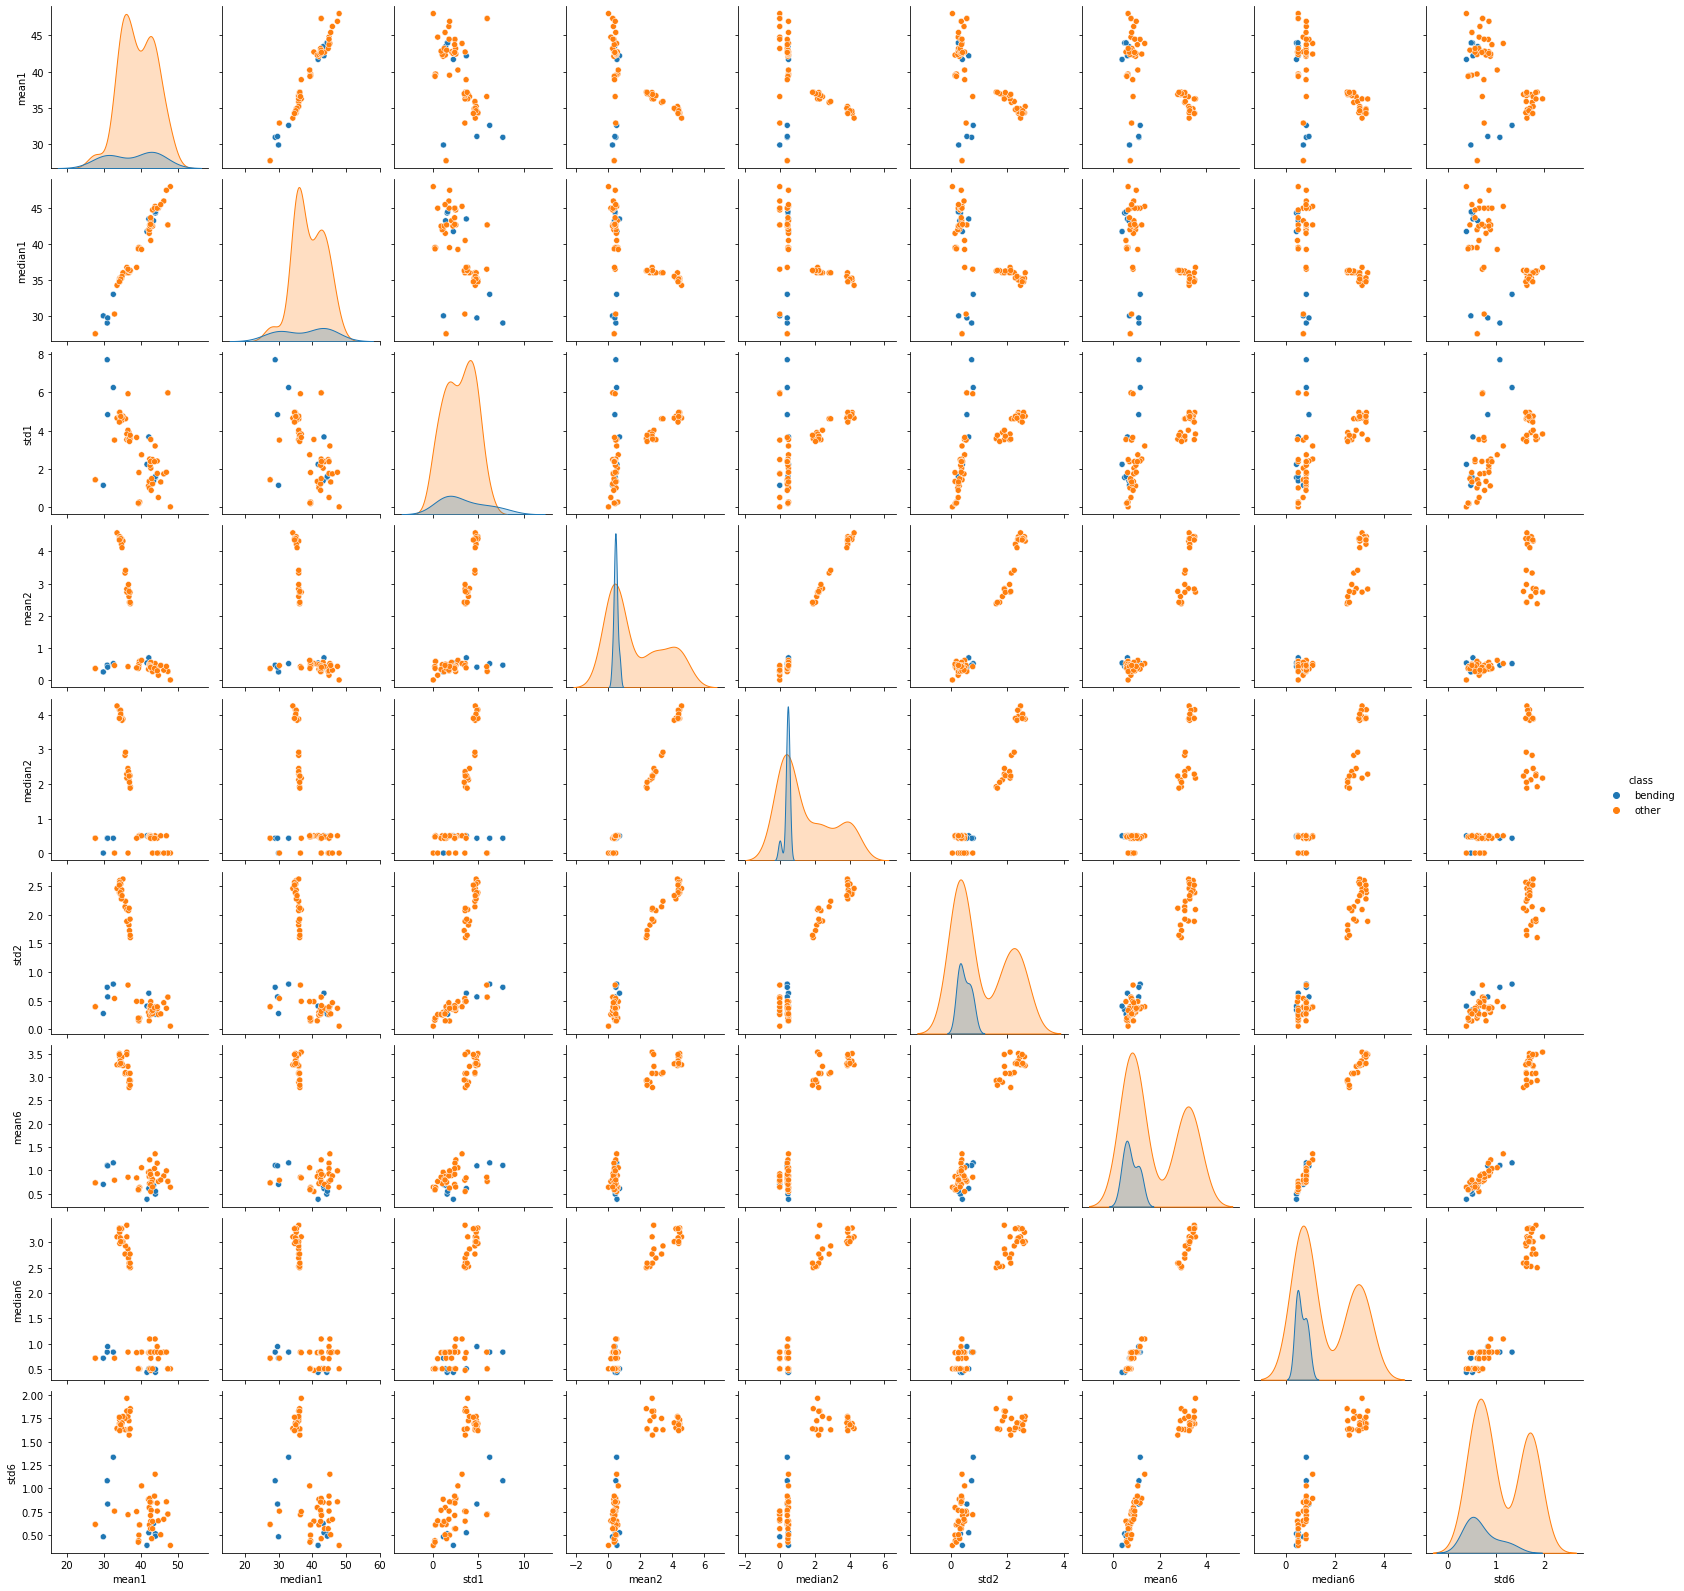

In [18]:
sns.pairplot(data=binary_train_df[make_cols],hue='class')

Helper function to split the data

In [19]:
def split_value(value,break_size):
    n=len(value)
    
    split_size=n//break_size
    start,end=0,split_size
    arr=[]
    while(end<=n):
        arr.append(value.iloc[start:end].reset_index())
        start=end
        end+=split_size
    #print(arr)
    return pd.concat(arr,axis=1).drop(columns='index')
        

In [20]:
def make_new_dataset_split_features(data,train_or_test,break_size):
    #get the number of features in the data
    
    col1=[str(x+1) for x in range(0,6*break_size)]
    
    col2=['min','max','mean','std','median','1st quart','3rd quart']
    new_col=[]
    for right in col1:
        for left in col2:
            new_col.append(left+right)

    new_col.append('class')
    new_col.append('train_or_test')
    
    data_new=[]
    for key in data:
        for value in data[key]:
            
            value=value.drop(columns=value.columns[0]) 
            new_value=split_value(value,break_size)
            data_new.append(make_columns(new_value,key,train_or_test))
        
    return pd.DataFrame(data_new,columns=new_col)
    

#### 2) a) ii) Splitting the timeseries data in half and making scatter plot for the new data

#### Comparing the scatterplots, there is not much considerable difference. The shape of the individual distributions are relatively similar to 2 a)i) and the pariwise distributions are similar as 2)a)i) for most pairwise plots due to simply breaking of data. There is some difference compared to 2)a)i but not considerable difference

min1   max1      mean1      std1  median1  1st quart1  3rd quart1  min2  \
0   38.75  45.00  43.629667  1.366867   44.330      42.250     44.5000  0.00   
1   35.75  47.75  43.995000  2.916867   45.000      43.750     45.3725  0.00   
2   33.75  45.00  40.910000  2.905104   41.585      39.000     43.0625  0.00   
3   41.00  46.75  44.932583  0.562444   45.000      45.000     45.0000  0.00   
4   40.75  45.00  42.798750  0.924801   42.500      42.000     43.5000  0.00   
..    ...    ...        ...       ...      ...         ...         ...   ...   
64  23.00  46.00  35.401917  4.590478   35.585      32.565     39.0000  0.00   
65  21.50  44.50  34.206333  4.418114   34.775      31.500     37.2500  0.00   
66  18.33  43.33  33.655333  5.328877   34.125      30.330     37.5000  0.00   
67  19.33  44.00  35.644583  4.763428   36.500      33.000     39.0000  0.47   
68  23.67  42.75  34.384333  4.589173   35.000      31.500     37.6900  0.00   

     max2     mean2  ...  3rd quart23  min24  max24    mean24     std24  \
0    1.50  0.374333  ...      36.3300   0.00   1.50  0.272500  0.397433   
1    3.00  0.508083  ...      30.5425   0.00   2.18  0.618167  0.500870   
2    2.17  0.630833  ...      30.0000   0.00   1.00  0.289667  0.265114   
3    1.30  0.096500  ...      23.8500   0.00   4.06  0.525000  0.581574   
4    1.12  0.383750  ...      23.5000   0.00   2.96  0.735000  0.522758   
..    ...       ...  ...          ...    ...    ...       ...       ...   
64   9.07  3.965417  ...      18.2700   0.43   7.85  3.513500  1.528461   
65  10.71  4.236417  ...      18.2500   0.00  10.21  3.245583  1.709250   
66  10.82  4.331417  ...      18.0625   0.00   7.46  3.314333  1.747398   
67  12.38  4.253750  ...      18.0625   0.50   8.84  3.388500  1.659594   
68  14.50  4.289583  ...      18.2500   0.43   8.09  3.385750  1.621069   

    median24  1st quart24  3rd quart24     class  train_or_test  
0      0.000       0.0000        0.470  bending1          train  
1      0.470       0.4300        0.870  bending1          train  
2      0.430       0.0000        0.500  bending1          train  
3      0.470       0.0000        0.710  bending1          train  
4      0.765       0.4600        0.940  bending1          train  
..       ...          ...          ...       ...            ...  
64     3.395       2.6725        4.275   walking          train  
65     3.075       2.0500        4.320   walking          train  
66     3.020       2.0500        4.380   walking          train  
67     3.200       2.2875        4.150   walking          train  
68     3.310       2.2875        4.425   walking          train  

[69 rows x 170 columns]

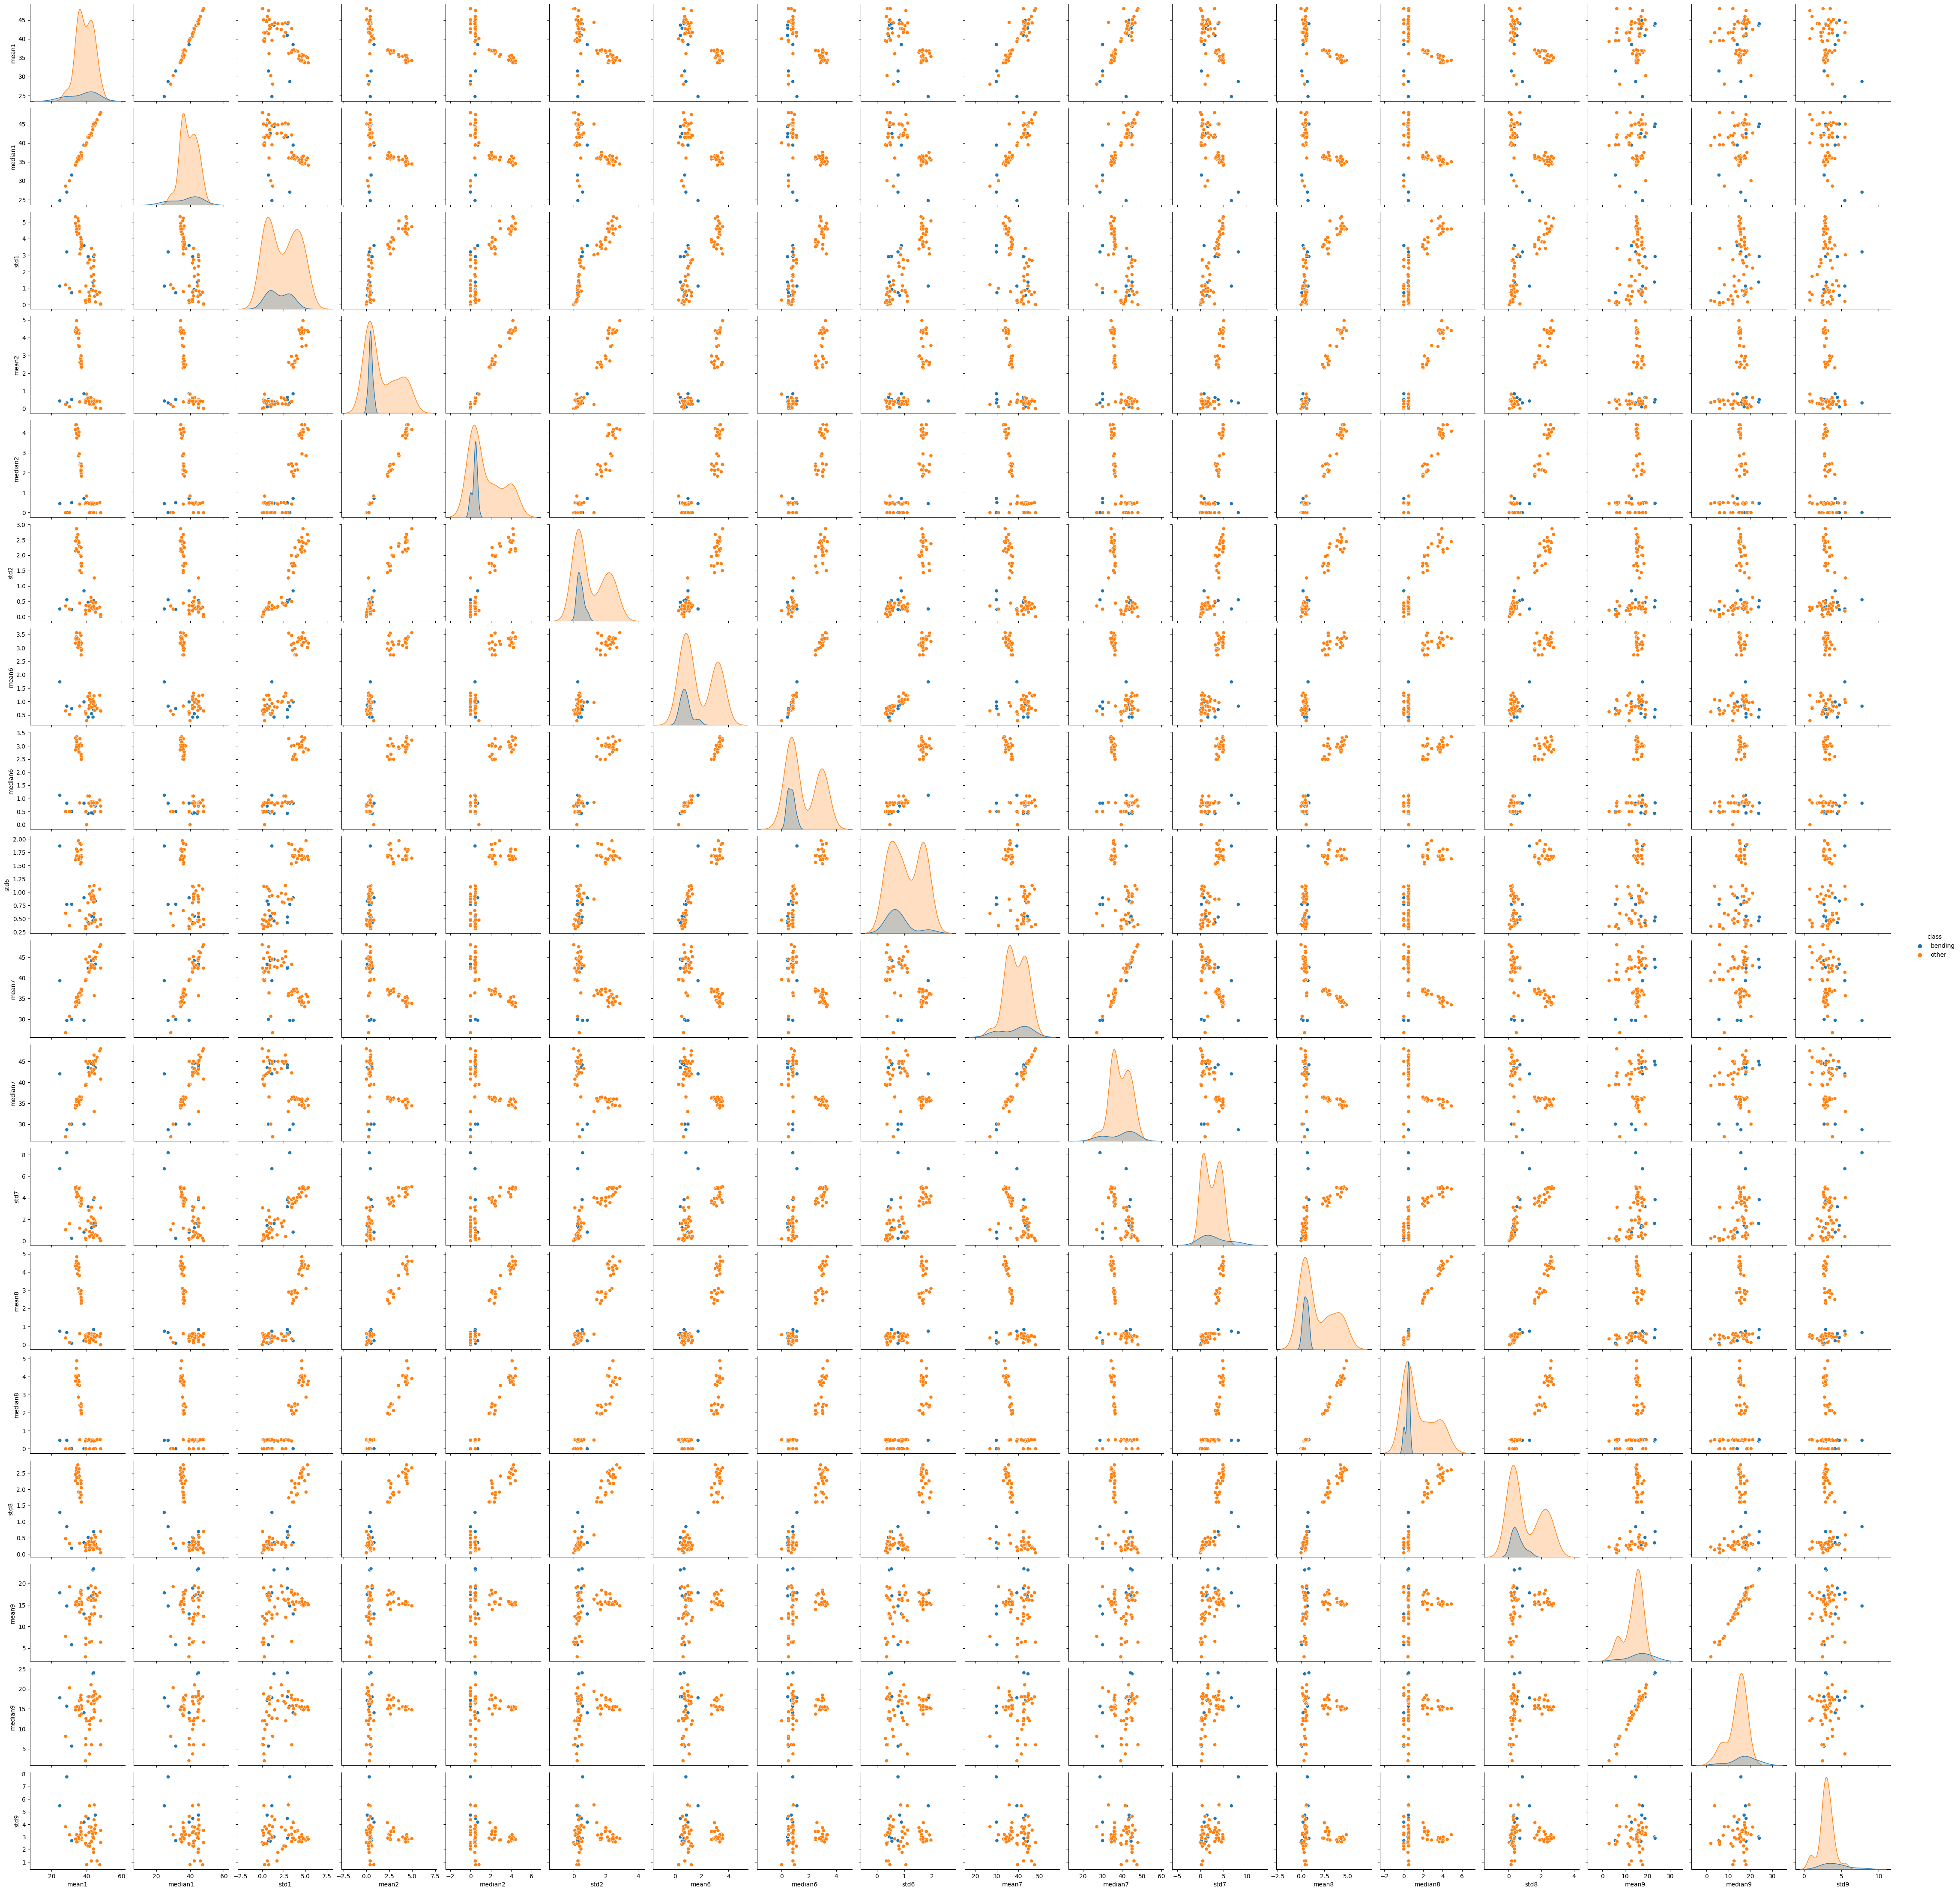

In [21]:
train_df_split_2=make_new_dataset_split_features(train_data,'train',4)
display(train_df_split_2)
make_cols=cols_plot(imp_features=['mean','median','std'],col_index=['1','2','6','7','8','9'])
train_df_split_2['class']=train_df_split_2['class'].apply(lambda x: 'bending' if x=='bending1' or x=='bending2' else 'other')
sns.pairplot(data=train_df_split_2[make_cols],hue='class')

### 2) a) iii) Calculating the best feature size p for every l {1..20}


####  Wrong way to perform cross validation : Use all the data in hand (combining train and test) to get the best features and the accuracy of that l,p pair to build the final model. This is wrong as we are leaking our test data while choosing best features and model selection. We are infact reducing the generalizing ability of model because of leaking the test data.

#### Right way to perform cross validation : Separate train and test data before performing cross validation. Perform cross validation on the train data. That is the train data is further divided into train and validation data during cross validation and no knowledge of test data anywhere. We choose the best features and model and finally at the end this is tested against test data to get test error. For cross validation for feature selection, the right way is to do cross validation while choosing the best p size which is done using RFECV automatically.

#### The best l,p pair is l=1, p=6, since checking the accuracy on fitting the training data is 1 and I also ran it over another nested loop of cross validation. I got l=1,p=6 as the best accuracy. I removed that since it was taking a lot of time to run and directly fitting on entire train data was giving results

Function to get calculate the accuracy for each l,p pair

In [22]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.pipeline import Pipeline
from numpy import mean
from collections import Counter
def get_best_lp(model,smote=None):
    for l in range(1,21):
        
        rfe=RFECV(model,cv=StratifiedKFold(n_splits=5),scoring='accuracy')
        
        temp_data=make_new_dataset_split_features(train_data,'train',l)
        col_index=[str(x) for x in range(1,l*6+1)]
        make_cols=cols_plot(imp_features=['mean','median','std'],col_index=col_index)
        
        X,y=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x: 'bending' if x=='bending1' or x=='bending2' else 'other')
        
        
        if smote!=None:
            X,y=smote.fit_resample(X, y)
        
        rfe.fit(X,y)
        chosen_cols=[]
        
        
        for i in range(0,len(X.columns)):
            if rfe.support_[i]:
                chosen_cols.append(X.columns[i])
        print('l=',l,'p=',len(chosen_cols),rfe.score(X,y),chosen_cols,'Class balance:',Counter(y))
        #print('l=',l,mean(cv_score),chosen_cols,'Class balance:',Counter(y))

In [23]:
get_best_lp(LogisticRegression(max_iter=500))

l= 1 p= 6 1.0 ['mean1', 'mean2', 'median3', 'median4', 'mean5', 'std5'] Class balance: Counter({'other': 60, 'bending': 9})
l= 2 p= 10 1.0 ['median3', 'median4', 'mean5', 'median5', 'std5', 'mean6', 'median7', 'mean8', 'median10', 'mean11'] Class balance: Counter({'other': 60, 'bending': 9})
l= 3 p= 1 0.9710144927536232 ['mean5'] Class balance: Counter({'other': 60, 'bending': 9})
l= 4 p= 1 0.8695652173913043 ['mean14'] Class balance: Counter({'other': 60, 'bending': 9})
l= 5 p= 1 0.8695652173913043 ['median22'] Class balance: Counter({'other': 60, 'bending': 9})
l= 6 p= 1 0.8695652173913043 ['median28'] Class balance: Counter({'other': 60, 'bending': 9})
l= 7 p= 2 0.9710144927536232 ['mean5', 'mean11'] Class balance: Counter({'other': 60, 'bending': 9})
l= 8 p= 1 0.9710144927536232 ['mean5'] Class balance: Counter({'other': 60, 'bending': 9})
l= 9 p= 1 0.9710144927536232 ['mean5'] Class balance: Counter({'other': 60, 'bending': 9})
l= 10 p= 10 1.0 ['mean5', 'median5', 'mean11', 'media

#### 2 a) iv) Confusion Matrix, ROC and AUC on test and train data for the model with best l,p = (1,6) pair.

C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


    const      mean1     mean2  median3  median4      mean5      std5
0     1.0  43.954500  0.426250   23.000    0.430  35.588458  1.999604
1     1.0  42.179813  0.696042   23.000    0.830  33.493917  3.849448
2     1.0  41.678063  0.535979   19.125    0.500  29.857083  2.411026
3     1.0  43.454958  0.378083   15.000    0.500  23.034792  2.488862
4     1.0  43.969125  0.413125   16.250    0.470  22.103750  3.318301
..    ...        ...       ...      ...      ...        ...       ...
64    1.0  34.763333  4.223792   15.330    3.000  16.299563  3.174681
65    1.0  34.935813  4.115750   15.500    2.870  15.997229  3.192058
66    1.0  34.333042  4.396958   15.500    2.930  15.864438  3.000493
67    1.0  34.599875  4.398833   15.000    3.015  16.055563  2.905688
68    1.0  34.225875  4.354500   15.500    3.030  16.148000  2.992920

[69 rows x 7 columns] 0     1
1     1
2     1
3     1
4     1
     ..
64    0
65    0
66    0
67    0
68    0
Name: class, Length: 69, dtype: int64
Accuracy= 1

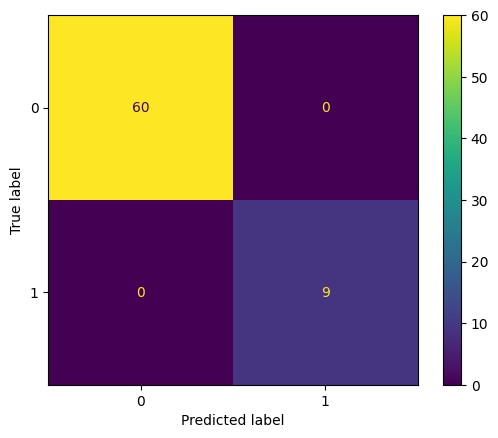

In [24]:
#Model with best L and P 

best_l_data=make_new_dataset_split_features(train_data,'train',1)
x_train,y_train=best_l_data[['mean1', 'mean2', 'median3', 'median4', 'mean5', 'std5']],best_l_data['class'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_train=sm.add_constant(x_train)
print(x_train,y_train)

best_l_model = sm.Logit(y_train, x_train).fit(method='lbfgs')
y_pred_raw=best_l_model.predict(x_train)
y_pred=round(y_pred_raw)

print('Accuracy=',accuracy_score(y_train,y_pred))
disp=ConfusionMatrixDisplay(confusion_matrix(y_train,y_pred))
disp.plot()
plt.show()

In [25]:
best_l_model.summary()

C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                  class   No. Observations:                   69
Model:                          Logit   Df Residuals:                       62
Method:                           MLE   Df Model:                            6
Date:                Tue, 18 Oct 2022   Pseudo R-squ.:                   1.000
Time:                        23:10:08   Log-Likelihood:            -0.00039367
converged:                      False   LL-Null:                       -26.718
Covariance Type:            nonrobust   LLR p-value:                 9.591e-10
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -3.8873   1.79e+08  -2.17e-08      1.000   -3.51e+08    3.51e+08
mean1        -44.1262   7.88e+07   -5.6e-07      1.000   -1.54e+08    1.54e+08
mean2        -65.4315    8.1e+08  -8.08e-08      1.000   -1.59e+09    1.59e+09
median3      -44.2130   1.63e+08  -2.71e-07      1.000   -3.19e+08    3.19e+08
median4      -54.3631   5.85e+09   -9.3e-09      1.000   -1.15e+10    1.15e+10
mean5        109.7497   2.02e+08   5.43e-07      1.000   -3.96e+08    3.96e+08
std5          89.8078   1.18e+09    7.6e-08      1.000   -2.32e+09    2.32e+09
==============================================================================

Possibly complete quasi-separation: A fraction 0.97 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

### ROC and AUC

AUC= 1.0


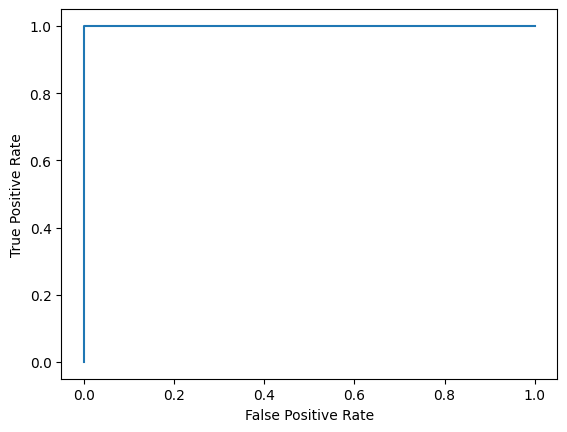

In [26]:
# T0-D0 Do ROC AUC Curve
fpr, tpr, thresholds = roc_curve(y_train, y_pred_raw)
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
print('AUC=',roc_auc_score(y_train,y_pred_raw))

### 2) a) v) Testing on test set. 
#### The accuracy I obtained on the test data is 1 and the accuracy I obtained on the train data is also 1. This is probably because the data is well separable. The score obtained in cross validation is 0.96 on train data

In [27]:
#testing
def makexy_data(data,x_cols):
    new_data=make_new_dataset_split_features(data,'test',1)
    x,y=new_data[x_cols],new_data['class'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
    return x,y

### 2) a) vi)There is an instable in calculating the logistic regression parameters. This is because the classes are well separated which causes the iterative approach to identify the parameters fail. This is also visible from the warning given by statsmodel below

In [28]:
x_test,y_test=makexy_data(test_data,['mean1', 'mean2', 'median3', 'median4', 'mean5', 'std5'])
x_test=sm.add_constant(x_test)
y_pred=best_l_model.predict(x_test)
accuracy_score(y_test,round(y_pred))

C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


1.0

#### 2) a) vii) Finding best l,p pair with case control sampling using smote. I chose sampling strategy = 0.2 based on the variance vs ratio of control/case taught in class. So i chose 1/5 which is 0.2
#### Showing the confusion matrix, AUC, ROC, etc 

In [29]:
oversample=SMOTE()


In [30]:
get_best_lp(LogisticRegression(max_iter=500),SMOTE(sampling_strategy=0.2,random_state=1))

l= 1 p= 7 1.0 ['mean1', 'mean2', 'median3', 'median4', 'mean5', 'std5', 'mean6'] Class balance: Counter({'other': 60, 'bending': 12})
l= 2 p= 7 1.0 ['median3', 'median4', 'mean5', 'median5', 'std5', 'mean6', 'median7'] Class balance: Counter({'other': 60, 'bending': 12})
l= 3 p= 3 1.0 ['mean3', 'mean5', 'median5'] Class balance: Counter({'other': 60, 'bending': 12})
l= 4 p= 7 1.0 ['std3', 'mean5', 'median5', 'median13', 'std13', 'mean16', 'mean23'] Class balance: Counter({'other': 60, 'bending': 12})
l= 5 p= 2 0.9722222222222222 ['mean5', 'median22'] Class balance: Counter({'other': 60, 'bending': 12})
l= 6 p= 11 1.0 ['mean5', 'median5', 'mean11', 'median11', 'median19', 'std19', 'mean22', 'mean26', 'mean28', 'median28', 'mean35'] Class balance: Counter({'other': 60, 'bending': 12})
l= 7 p= 7 1.0 ['mean5', 'median5', 'mean11', 'mean15', 'std19', 'mean41', 'median41'] Class balance: Counter({'other': 60, 'bending': 12})
l= 8 p= 8 1.0 ['mean5', 'median5', 'mean11', 'median11', 'median15'

In [31]:
def print_confusion_matrix(y_true,y_pred,title):
    disp=ConfusionMatrixDisplay(confusion_matrix(y_true,y_pred))
    disp.plot()
    plt.title(title)
    plt.show()

For train data


C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\base\model.py:547: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


Accuracy= 1.0


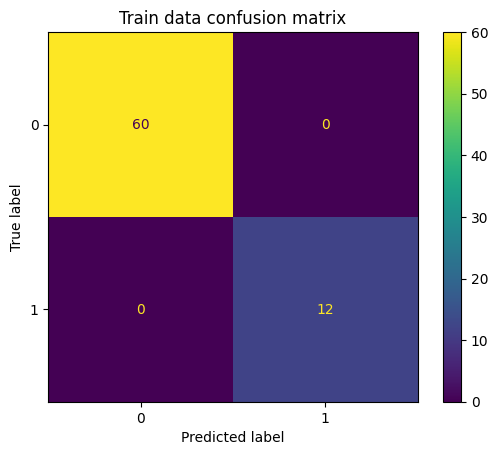

For test data:
Accuracy= 1.0


C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  x = pd.concat(x[::order], 1)
C:\Users\rosha\anaconda3\lib\site-packages\statsmodels\discrete\discrete_model.py:1810: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


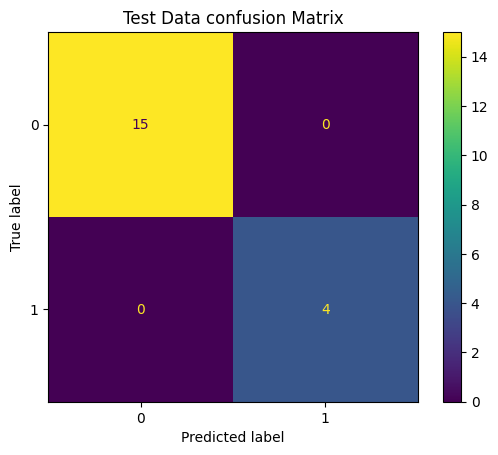

In [32]:
#Model with best L and P balanced data
print('For train data')
best_l_data=make_new_dataset_split_features(train_data,'train',1)
x_train,y_train=best_l_data[['mean1', 'mean2', 'median3', 'median4', 'mean5', 'std5', 'mean6']],best_l_data['class'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_train,y_train=SMOTE(sampling_strategy=0.2,random_state=1).fit_resample(x_train, y_train)
x_train=sm.add_constant(x_train)


best_l_model = sm.Logit(y_train, x_train).fit(method='lbfgs')
y_pred_raw_train=best_l_model.predict(x_train)
y_pred=round(y_pred_raw_train)

print('Accuracy=',accuracy_score(y_train,y_pred))
print_confusion_matrix(y_train,y_pred,'Train data confusion matrix')
#for test data

print('For test data:')
best_l_data=make_new_dataset_split_features(test_data,'test',1)
x_test,y_test=best_l_data[['mean1', 'mean2', 'median3', 'median4', 'mean5', 'std5', 'mean6']],best_l_data['class'].apply(lambda x: 1 if x=='bending1' or x=='bending2' else 0)
x_test=sm.add_constant(x_test)

y_pred_raw_test=best_l_model.predict(x_test)
y_pred=round(y_pred_raw_test)

print('Accuracy=',accuracy_score(y_test,y_pred))
print_confusion_matrix(y_test,y_pred,'Test Data confusion Matrix')

In [33]:
def make_roc_curve(y_train,y_pred_raw,title):
    fpr, tpr, thresholds = roc_curve(y_train, y_pred_raw)
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    print('AUC=',roc_auc_score(y_train,y_pred_raw))




AUC= 1.0


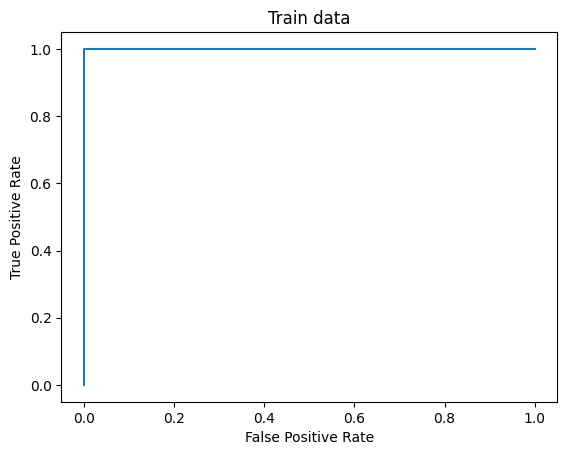

In [34]:
make_roc_curve(y_train,y_pred_raw_train,'Train data')

AUC= 1.0


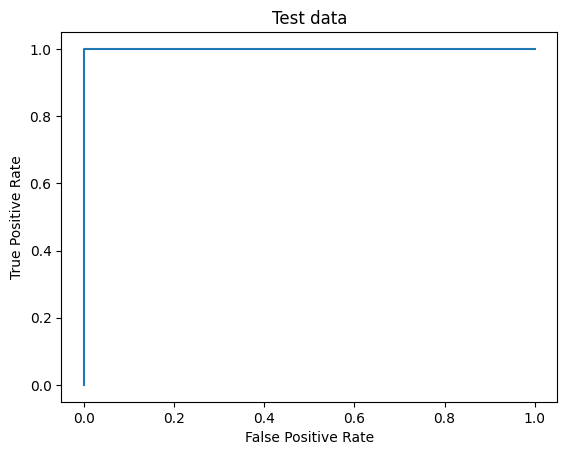

In [35]:
make_roc_curve(y_test,y_pred_raw_test,'Test data')

### B) Binary classification using L1 penalized logistic regression. Best (l,C) is (3,0.359)

#### 2)b)ii) L1 penalized is much easier to implement compared to variable selection using p values. As per the comparison of performance, L1 penalized runs faster and has slightly lesser compared to variable selection using p values (when comparing both the cross validation score as well as the score on entire train data). 

In [36]:
for l in range(1,21):

    temp_data=make_new_dataset_split_features(train_data,'train',l)
    col_index=[str(x) for x in range(1,l*6+1)]
    make_cols=cols_plot(imp_features=['mean','median','std'],col_index=col_index)
    
    X,y=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x: 'bending' if x=='bending1' or x=='bending2' else 'other')
    
    scaler = StandardScaler().fit(X)
    X=scaler.transform(X)
    
    cv=StratifiedKFold(n_splits=5)
    l1_model=LogisticRegressionCV(cv=5,penalty='l1',solver='liblinear',random_state=1)
    l1_model.fit(X,y)
    #print(l,accuracy_score(y,l1_model.predict(X)))
    cv_score=cross_val_score(l1_model,X,y,cv=cv)  
    #print(l,mean(cv_score))
    print(l,l1_model.C_,mean(cv_score))
    


1 [0.35938137] 0.9131868131868132
2 [2.7825594] 0.9428571428571428
3 [0.35938137] 0.9571428571428573
4 [0.35938137] 0.9571428571428573
5 [2.7825594] 0.9428571428571428
6 [2.7825594] 0.9571428571428573
7 [0.35938137] 0.9131868131868132
8 [2.7825594] 0.8846153846153847
9 [0.35938137] 0.9131868131868132
10 [2.7825594] 0.9285714285714285
11 [2.7825594] 0.9428571428571428
12 [2.7825594] 0.9285714285714285
13 [0.35938137] 0.9428571428571428
14 [2.7825594] 0.9131868131868132
15 [0.35938137] 0.9131868131868132
16 [2.7825594] 0.9131868131868132
17 [21.5443469] 0.9285714285714285
18 [2.7825594] 0.9428571428571428
19 [2.7825594] 0.9142857142857143
20 [2.7825594] 0.9571428571428573


### c) Multiclass classification

#### 2) c) i) Best L obtained is 1. The test error is 0.052 which is calculated below. Added confusion matrices and ROC as well. 
#### For ROC curves in multiclass classification we need to labelize the output and a ROC curve considering each class as positive class is obtained and displayed in the same graph. Same is the case for confusion matrix

In [37]:
l1_multi_models=dict()
for l in range(1,21):

    temp_data=make_new_dataset_split_features(train_data,'train',l)
    col_index=[str(x) for x in range(1,l*6+1)]
    make_cols=cols_plot(imp_features=['mean','median','std'],col_index=col_index)
    X,y=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')
    #print(Counter(y))
    scaler = StandardScaler().fit(X)
    X=scaler.transform(X)
    
    cv=StratifiedKFold(n_splits=5)
    l1_model=LogisticRegressionCV(max_iter=500,cv=5,penalty='l1',solver='liblinear')
    l1_model.fit(X,y)
    l1_multi_models[l]={'model':l1_model,'scaler':scaler}
    cv_score=cross_val_score(l1_model,X,y,cv=cv)  
    
    print(l,l1_model.C_,mean(cv_score))
    

1 [2.7825594 2.7825594 2.7825594 2.7825594 2.7825594 2.7825594] 0.8549450549450549
2 [2.15443469e+01 2.78255940e+00 2.78255940e+00 1.00000000e+04
 2.78255940e+00 2.78255940e+00] 0.856043956043956
3 [ 2.7825594  2.7825594  2.7825594 21.5443469  2.7825594  2.7825594] 0.8549450549450549
4 [  2.7825594    2.7825594    2.7825594   21.5443469  166.81005372
   2.7825594 ] 0.8263736263736263
5 [3.59381366e-01 2.78255940e+00 2.78255940e+00 1.00000000e+04
 2.78255940e+00 3.59381366e-01] 0.7384615384615385
6 [2.78255940e+00 2.78255940e+00 3.59381366e-01 1.00000000e+04
 2.78255940e+00 3.59381366e-01] 0.7692307692307693
7 [3.59381366e-01 2.78255940e+00 2.78255940e+00 3.59381366e-01
 1.29154967e+03 2.78255940e+00] 0.7230769230769231
8 [3.59381366e-01 2.78255940e+00 1.29154967e+03 1.00000000e+04
 3.59381366e-01 2.78255940e+00] 0.7681318681318682
9 [0.35938137 2.7825594  2.7825594  0.35938137 0.35938137 0.35938137] 0.7692307692307693
10 [2.78255940e+00 1.29154967e+03 2.78255940e+00 1.00000000e+04
 3.5

In [38]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
def get_roc_auc_multi(X,y,model,title):
    n_classes=(y.unique())
    y_test = label_binarize(y, classes=n_classes)
    #print(y_test)
    y_score=model.predict_proba(X)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(len(n_classes)):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    for i in range(len(n_classes)):
        plt.plot(fpr[i], tpr[i], label='ROC curve of class {0} (area = {1:0.2f})'
                                    ''.format(i, roc_auc[i]))
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.title(title)
    plt.show()

Train error 0.04347826086956519


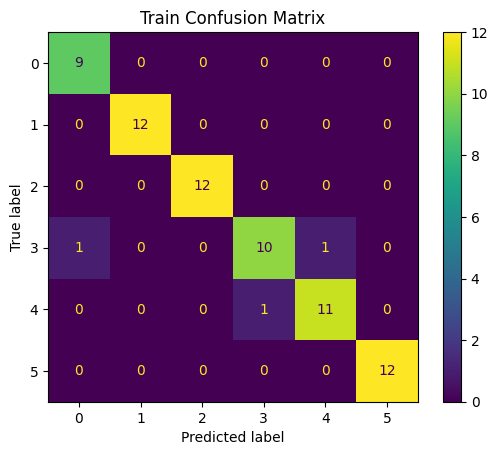

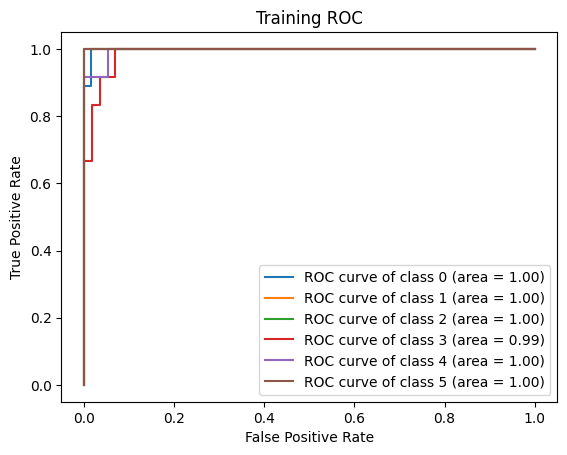

Test error 0.052631578947368474
Test Confusion matrix 


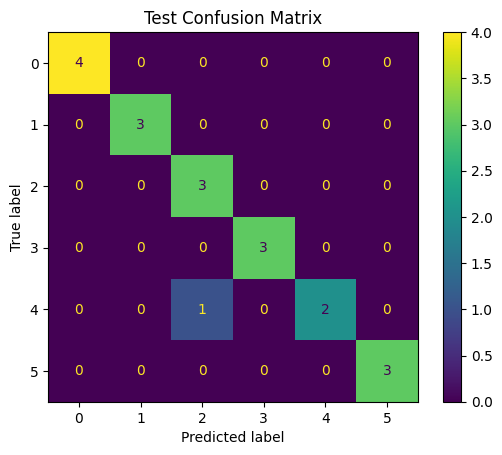

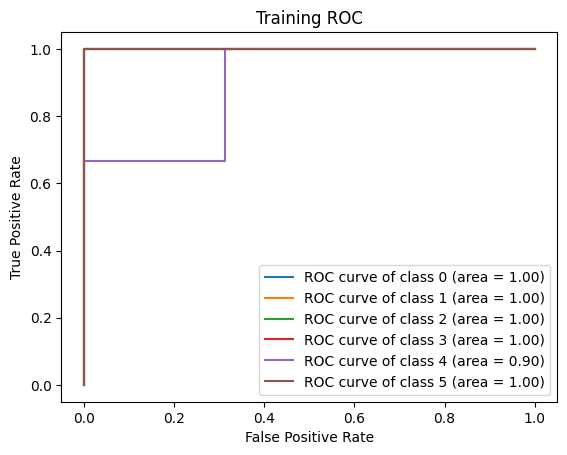

In [39]:
#testing on test data
l=1
temp_data=make_new_dataset_split_features(train_data,'train',l)
col_index=[str(x) for x in range(1,l*6+1)]
make_cols=cols_plot(imp_features=['mean','median','std'],col_index=col_index)

X,y=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')
X_train=l1_multi_models[l]['scaler'].transform(X)
y_pred=l1_multi_models[l]['model'].predict(X_train)
y_pred_raw=l1_multi_models[l]['model'].predict_proba(X_train)
#print(y_train)
print('Train error',1-accuracy_score(y,y_pred))

print_confusion_matrix(y,y_pred,'Train Confusion Matrix')
get_roc_auc_multi(X_train,y,l1_multi_models[l]['model'],'Training ROC')


temp_data=make_new_dataset_split_features(test_data,'test',l)
X_test,y_test=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

X_test=l1_multi_models[l]['scaler'].transform(X_test)
y_pred=l1_multi_models[l]['model'].predict(X_test)
y_pred_raw=l1_multi_models[l]['model'].predict_proba(X_test)
print('Test error',1-accuracy_score(y_test,y_pred))
print('Test Confusion matrix ')
print_confusion_matrix(y_test,y_pred,'Test Confusion Matrix')
get_roc_auc_multi(X_test,y_test,l1_multi_models[l]['model'],'Training ROC')

### c ii) Gaussian NB .
#### Best l obtained is l=10 with cross validation accuracy of 0.85 on train. The test error is  0.10526315789473684

In [40]:
for l in range(1,21):

    temp_data=make_new_dataset_split_features(train_data,'train',l)
    col_index=[str(x) for x in range(1,l*6+1)]
    make_cols=cols_plot(imp_features=['mean','median','std'],col_index=col_index)
    X,y=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')
    
    cv=StratifiedKFold(n_splits=5)
    gb_model=GaussianNB()
    
    chosen_cols=[]
    
    print(l,mean(cross_val_score(gb_model,X,y,cv=cv)))
    

1 0.8252747252747253
2 0.8274725274725275
3 0.7681318681318682
4 0.7967032967032968
5 0.8263736263736263
6 0.7967032967032966
7 0.7835164835164835
8 0.7967032967032966
9 0.7978021978021979
10 0.8549450549450549
11 0.7824175824175824
12 0.7967032967032968
13 0.7681318681318682
14 0.7824175824175824
15 0.7813186813186814
16 0.7527472527472527
17 0.8263736263736263
18 0.7527472527472527
19 0.7098901098901098
20 0.7813186813186812


Train error 0.01449275362318836


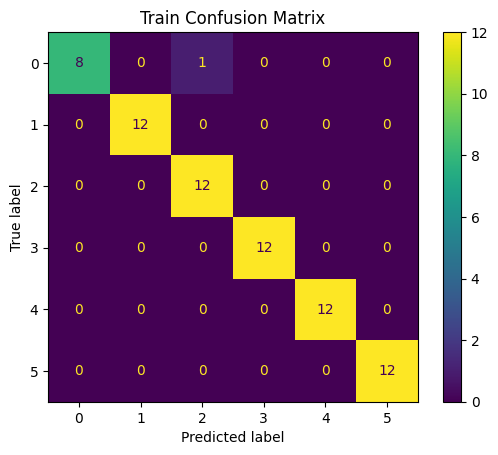

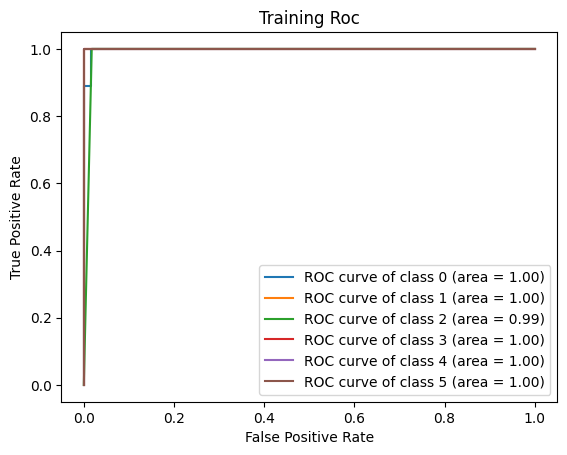

Test error 0.10526315789473684


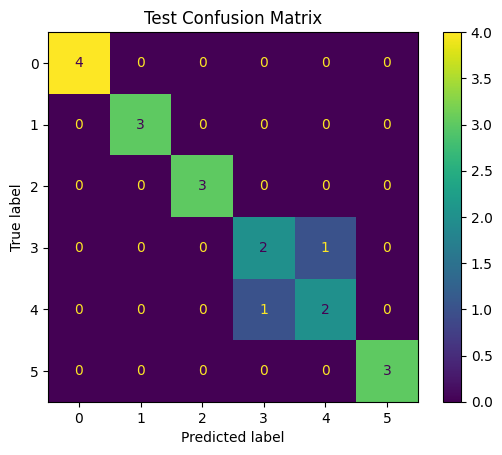

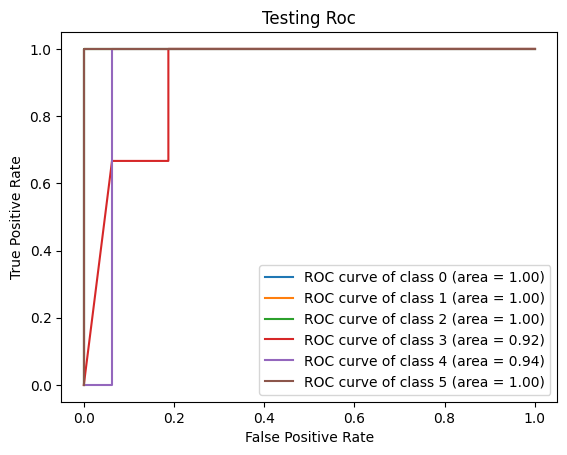

In [41]:
#Choosing l=10
l=10

temp_data=make_new_dataset_split_features(train_data,'train',l)
col_index=[str(x) for x in range(1,l*6+1)]
make_cols=cols_plot(imp_features=['mean','median','std'],col_index=col_index)
X,y=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

gb=GaussianNB()
gb.fit(X,y)
y_pred=gb.predict(X)
y_pred_raw=gb.predict_proba(X)
print('Train error',1-accuracy_score(y,y_pred))

print_confusion_matrix(y,y_pred,'Train Confusion Matrix')
get_roc_auc_multi(X,y,gb,'Training Roc')

temp_data=make_new_dataset_split_features(test_data,'test',l)
col_index=[str(x) for x in range(1,l*6+1)]
make_cols=cols_plot(imp_features=['mean','median','std'],col_index=col_index)
X_test,y_test=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

y_pred=gb.predict(X_test)
y_pred_raw=gb.predict_proba(X_test)
print('Test error',1-accuracy_score(y_test,y_pred))
print_confusion_matrix(y_test,y_pred,'Test Confusion Matrix')
get_roc_auc_multi(X_test,y_test,gb,'Testing Roc')


### 2 c) iii) Multinomial Naive Bayes
#### The best l value is 6 which has cross validation accuracy of 0.856. The test error is 0.105 and train error is 0.04

In [42]:
for l in range(1,21):

    temp_data=make_new_dataset_split_features(train_data,'train',l)
    col_index=[str(x) for x in range(1,l*6+1)]
    make_cols=cols_plot(imp_features=['mean','median','std'],col_index=col_index)
    X,y=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')
    
    cv=StratifiedKFold(n_splits=5)
    gb_model=MultinomialNB()
    
    chosen_cols=[]
    
    print(l,mean(cross_val_score(gb_model,X,y,cv=cv)))
    

1 0.7967032967032968
2 0.8120879120879121
3 0.7824175824175824
4 0.8263736263736263
5 0.8263736263736263
6 0.856043956043956
7 0.8263736263736263
8 0.8263736263736263
9 0.8406593406593407
10 0.8263736263736263
11 0.8406593406593406
12 0.8252747252747252
13 0.8263736263736263
14 0.8417582417582418
15 0.8406593406593406
16 0.8406593406593406
17 0.8252747252747252
18 0.810989010989011
19 0.8395604395604396
20 0.8252747252747252


Train error 0.04347826086956519


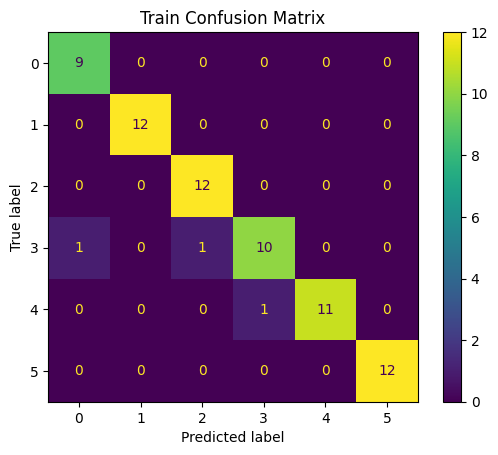

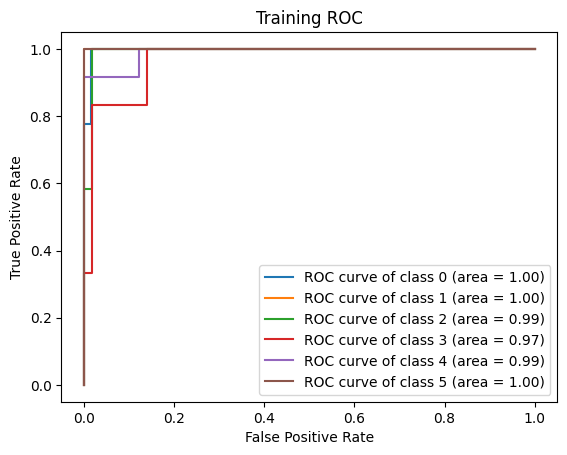

Test error 0.10526315789473684


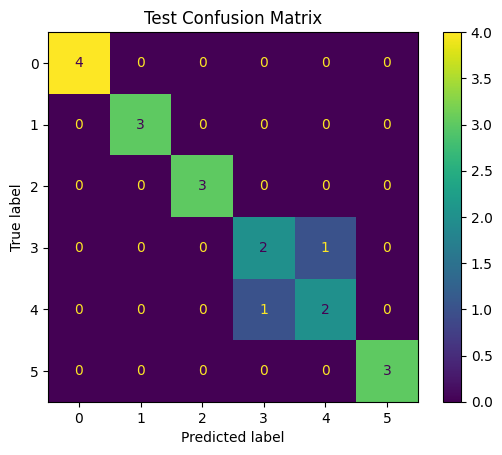

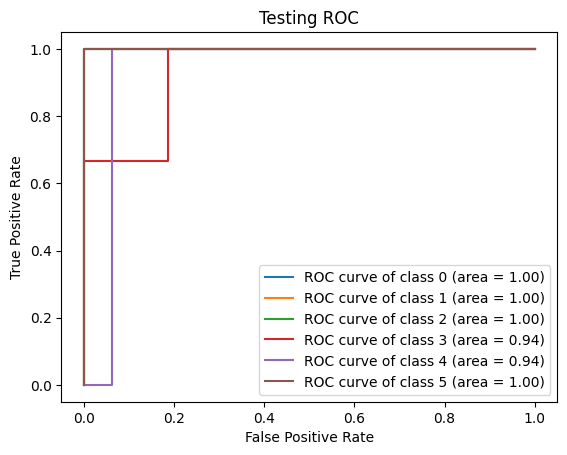

In [43]:
#Choosing l=6
l=6

temp_data=make_new_dataset_split_features(train_data,'train',l)
col_index=[str(x) for x in range(1,l*6+1)]
make_cols=cols_plot(imp_features=['mean','median','std'],col_index=col_index)
X,y=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

mb=MultinomialNB()
mb.fit(X,y)
y_pred=mb.predict(X)
y_pred_raw=mb.predict_proba(X)
print('Train error',1-accuracy_score(y,y_pred))
print_confusion_matrix(y,y_pred,'Train Confusion Matrix')
get_roc_auc_multi(X,y,mb,'Training ROC')
    
temp_data=make_new_dataset_split_features(test_data,'test',l)
col_index=[str(x) for x in range(1,l*6+1)]
make_cols=cols_plot(imp_features=['mean','median','std'],col_index=col_index)
X_test,y_test=temp_data[make_cols[1:]],temp_data['class'].apply(lambda x:x if x not in ['bending1','bending2'] else 'bending')

y_pred=mb.predict(X_test)
y_pred_raw=mb.predict_proba(X_test)
print('Test error',1-accuracy_score(y_test,y_pred))
print_confusion_matrix(y_test,y_pred,'Test Confusion Matrix')
get_roc_auc_multi(X_test,y_test,mb,'Testing ROC')
#make_roc_curve(y_test,y_pred_raw,'Test data')

## 3) ISLR 4.8.3

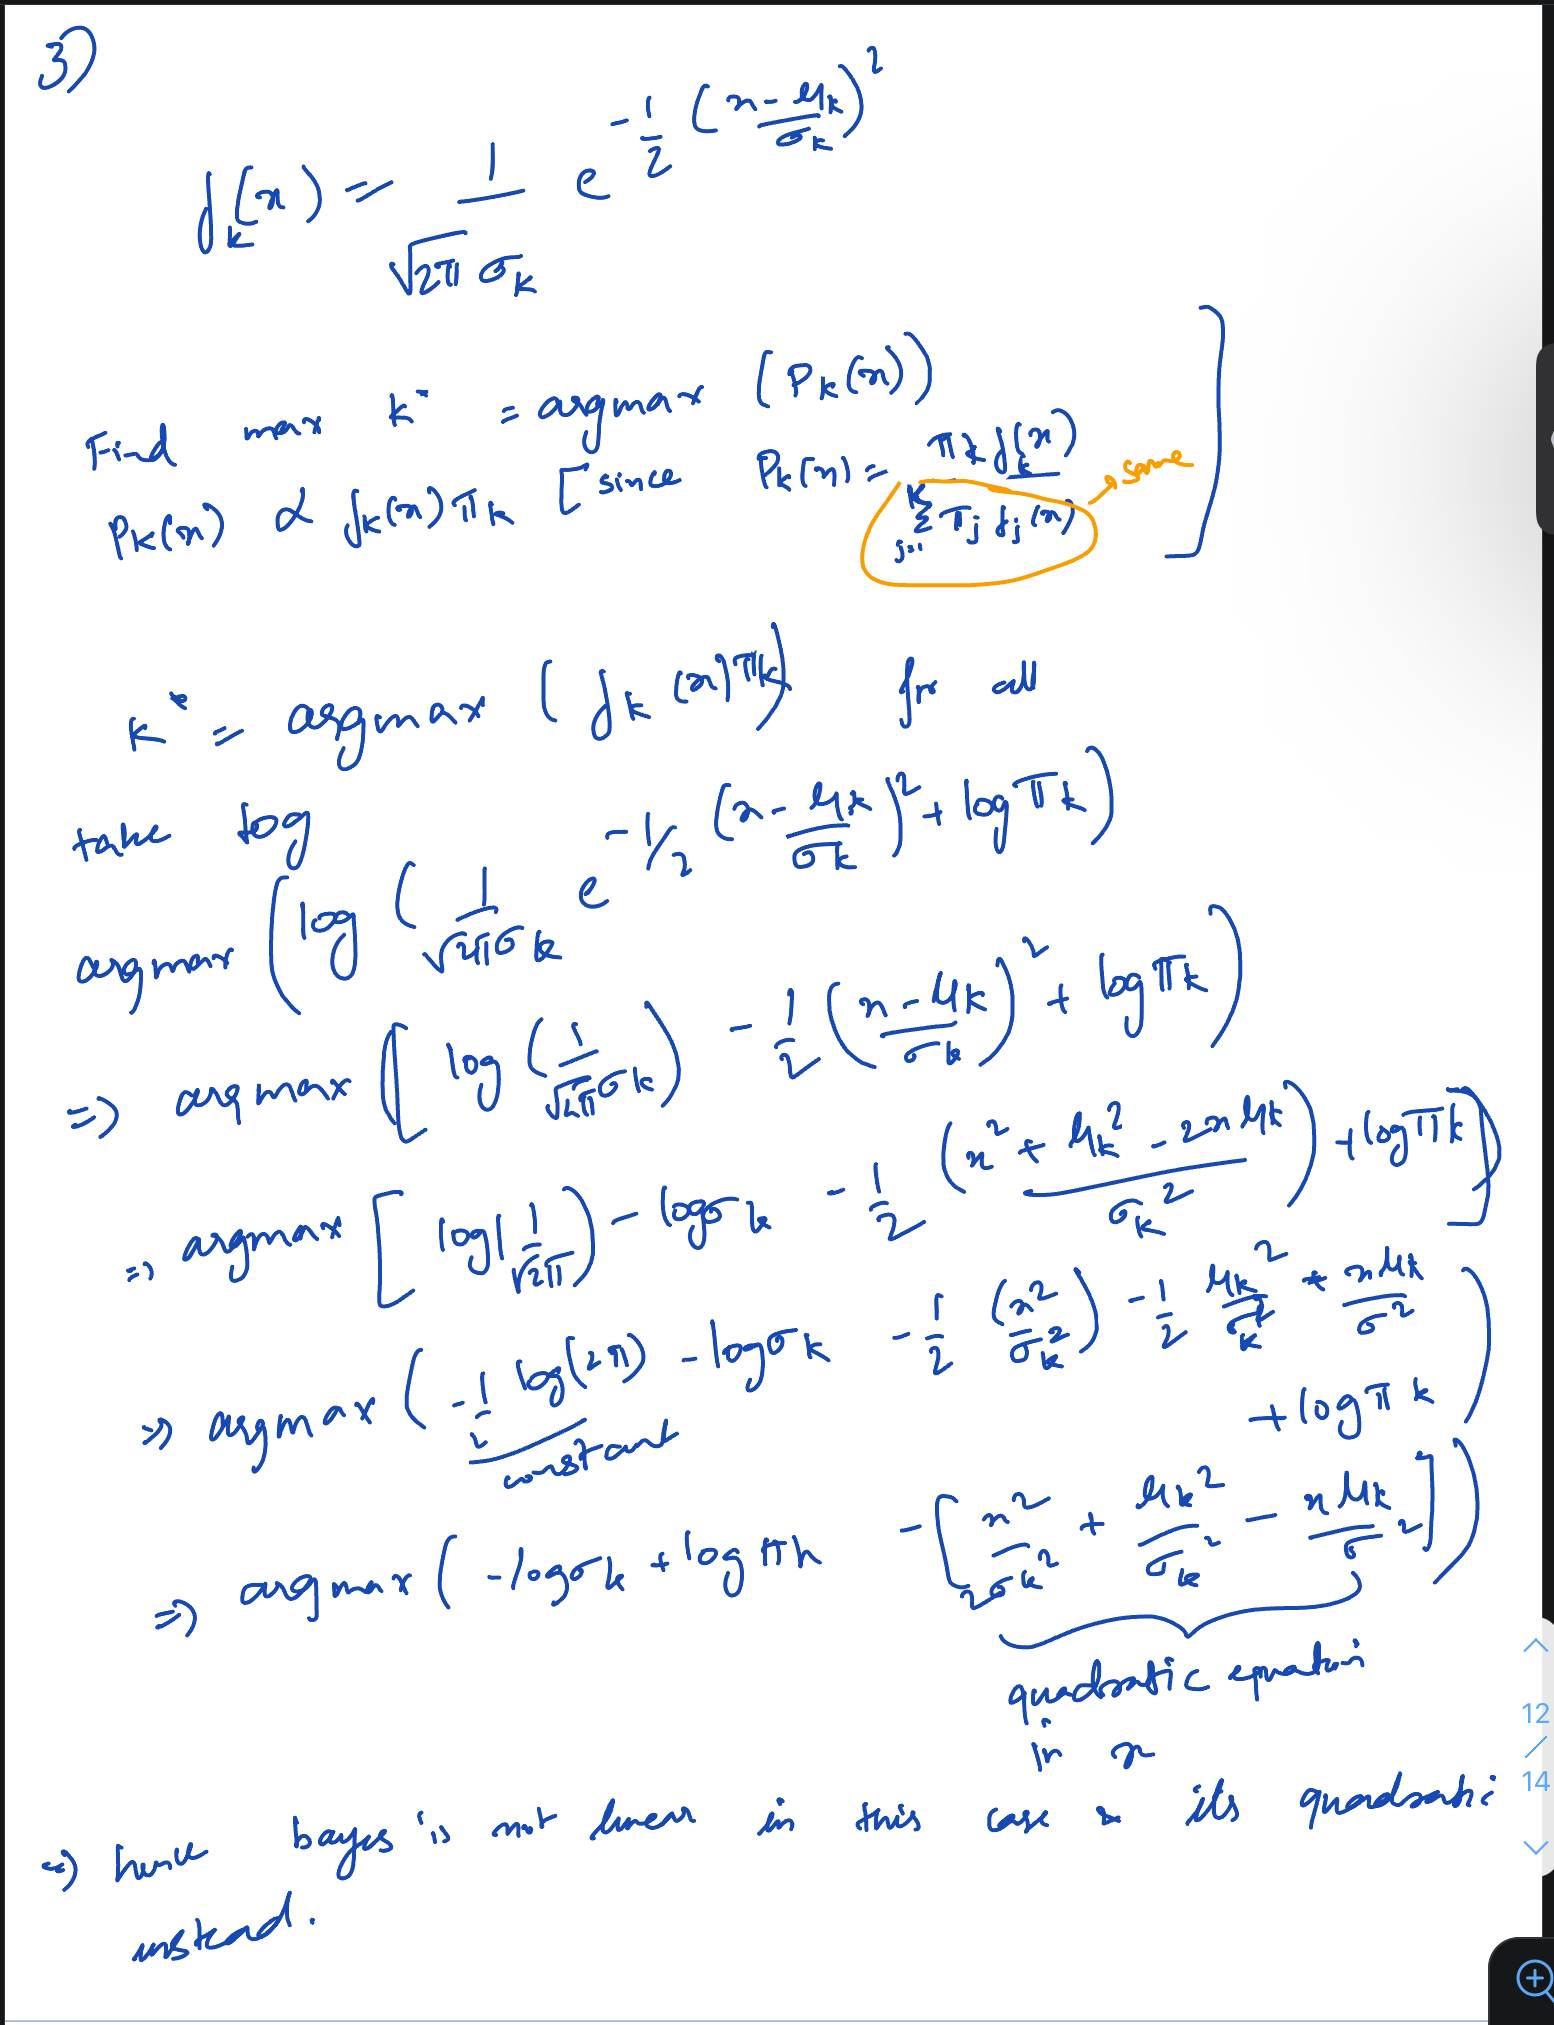

## 4) ISLR 4.8.7

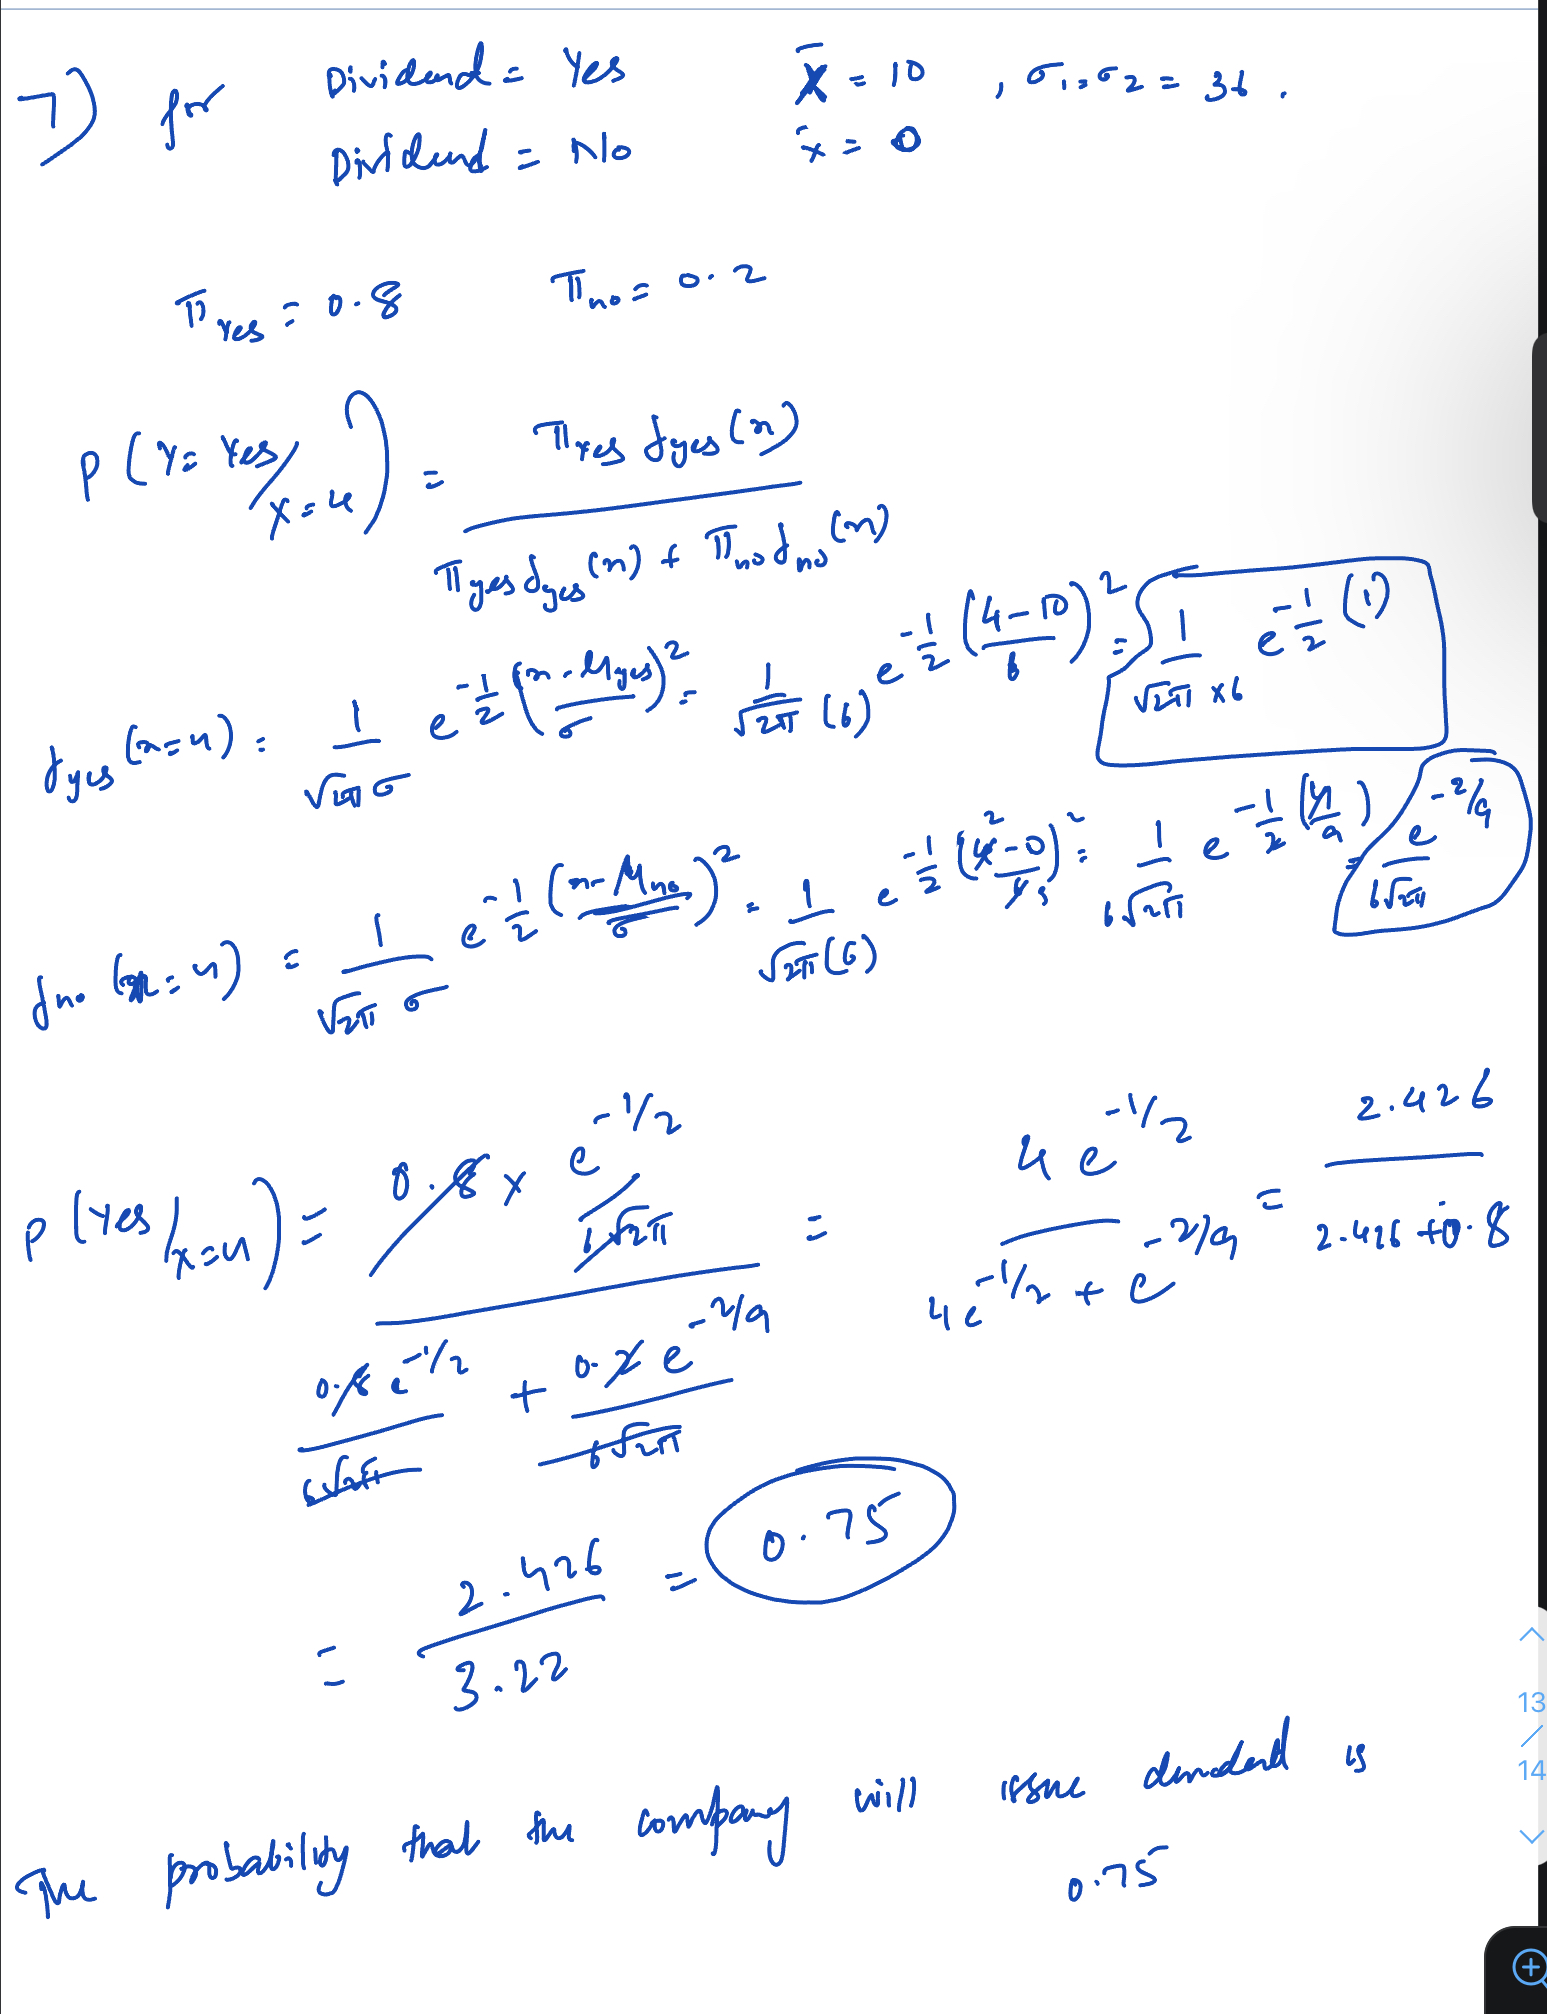